# Random Forest 异常检测评分器

本notebook实现了基于Random Forest的智能异常检测评分器，作为Seeker项目三维评分体系的升级方案。

## 架构
![](../slides/assets/diagram-random-forest-scorer-1.png)

## 🎯 核心优势

**vs 三维评分体系对比：**
- ✅ **自动权重学习**: 无需手工调参，从数据中学习最优权重
- ✅ **特征交互建模**: 能捕获算法间的复杂交互关系  
- ✅ **可解释性**: 可输出特征重要性，了解各算法贡献度
- ✅ **自适应能力**: 通过训练持续提升检测效果

## 🚀 技术架构

```
多算法检测 → 特征工程 → Random Forest → 异常评分 → 智能分级
    ↓           ↓          ↓         ↓         ↓
5种算法结果   增强特征    自动学习    0-1概率   P0/P1/P2
时序特征     交互特征    权重优化    置信区间   优先级
统计特征     邻域特征    特征重要性  业务指标   运维决策
```

## 📊 实验设计

1. **特征工程策略**: 基础特征 + 时序特征 + 交互特征
2. **模型训练方式**: 半监督学习 + 历史数据标注
3. **性能评估指标**: 准确率、召回率、F1-score、AUC
4. **对比基线**: 三维评分体系 vs Random Forest评分器

## 📋 Random Forest 训练数据要求

### 🎯 数据量要求
- **样本数量**: 最少1000+样本，建议5000+
- **异常比例**: 5-20% (过少学不到模式，过多影响模型泛化)
- **时间跨度**: 覆盖多个业务周期，确保季节性/周期性完整
- **特征维度**: 10-100个特征，避免维度过高导致过拟合

### 📊 数据质量标准

#### ✅ 标注质量
```
- 准确性: 异常标注准确率 > 95%
- 一致性: 同类异常标注标准统一
- 覆盖性: 包含各种异常类型
- 及时性: 异常发现到标注时间 < 24h
```

#### ✅ 数据完整性
```
- 缺失率: < 10% (RF可处理缺失值但影响性能)
- 连续性: 时序数据无大段缺失
- 准确性: 无明显的传感器故障数据
- 时间对齐: 多指标时间戳对齐
```

### 🔧 特征工程策略

#### 1️⃣ 基础特征 (Raw Metrics)
```python
primary_features = [
    'cpu_utilization',     # CPU使用率
    'memory_usage',        # 内存使用
    'disk_io_read',        # 磁盘读IO  
    'disk_io_write',       # 磁盘写IO
    'network_in',          # 网络入流量
    'network_out',         # 网络出流量
    'error_rate',          # 错误率
    'response_time'        # 响应时间
]
```

#### 2️⃣ 时序特征 (Temporal Features)  
```python
temporal_features = [
    'rolling_mean_5m',     # 5分钟滑动平均
    'rolling_std_15m',     # 15分钟滑动标准差
    'rolling_max_1h',      # 1小时滚动最大值
    'change_rate_5m',      # 5分钟变化率
    'trend_slope',         # 趋势斜率
    'hour_of_day',         # 小时特征
    'day_of_week',         # 星期特征
    'is_weekend',          # 是否周末
    'is_business_hour'     # 是否工作时间
]
```

#### 3️⃣ 算法特征 (Algorithm Scores)
```python
algorithm_features = [
    'isolation_forest_score',    # 孤立森林得分
    'lof_score',                # LOF局部异常因子
    'zscore_anomaly',           # Z-score阈值检测
    'statistical_outlier',      # 统计异常检测
    'threshold_violation',      # 阈值违规检测
    'ensemble_consensus',       # 集成一致性得分
    'confidence_interval',      # 置信区间偏离度
]
```

#### 4️⃣ 交互特征 (Interaction Features)
```python
interaction_features = [
    'cpu_memory_ratio',         # CPU与内存使用比
    'io_network_correlation',   # IO与网络相关性
    'error_response_product',   # 错误率×响应时间
    'load_efficiency_index',    # 负载效率指数
    'peak_baseline_ratio'       # 峰值与基线比
]
```

### 📈 数据分布要求

```python
# 推荐的数据分布
data_requirements = {
    "训练集": "70% (包含各种场景和异常类型)",
    "验证集": "15% (调参和特征选择)", 
    "测试集": "15% (最终性能评估)",
    "时间分割": "按时间顺序分割，避免数据泄漏",
    "异常分布": "各集合中异常比例保持一致"
}
```

### ⚠️ 数据准备注意事项

1. **避免数据泄漏**: 特征工程时不能使用未来信息
2. **时间对齐**: 确保所有指标在同一时间点对齐
3. **标准化**: 不同量纲的特征需要标准化处理
4. **异常类型平衡**: 确保各种异常类型都有足够样本
5. **业务场景覆盖**: 包含正常运行、负载高峰、故障恢复等场景

In [ ]:
# ============ 数据质量检查工具 ============

def check_data_quality(df, target_col='is_anomaly'):
    """
    检查训练数据质量
    
    Args:
        df: 数据DataFrame
        target_col: 目标列名
    """
    print("📊 数据质量报告")
    print("=" * 50)
    
    # 基本信息
    print(f"🔢 数据形状: {df.shape}")
    print(f"📅 时间跨度: {df.index.min()} 到 {df.index.max()}")
    
    # 目标分布
    if target_col in df.columns:
        anomaly_ratio = df[target_col].mean()
        print(f"🎯 异常比例: {anomaly_ratio:.2%}")
        
        if anomaly_ratio < 0.05:
            print("⚠️  警告: 异常样本过少，可能导致模型学习不充分")
        elif anomaly_ratio > 0.2:
            print("⚠️  警告: 异常样本过多，可能影响模型泛化能力")
        else:
            print("✅ 异常比例合理")
    
    # 缺失值检查
    missing_stats = df.isnull().sum()
    missing_ratio = missing_stats / len(df)
    
    print(f"\n📋 缺失值统计:")
    problematic_cols = missing_ratio[missing_ratio > 0.1]
    if len(problematic_cols) > 0:
        print("⚠️  高缺失率特征 (>10%):")
        for col, ratio in problematic_cols.items():
            print(f"   {col}: {ratio:.2%}")
    else:
        print("✅ 所有特征缺失率 < 10%")
    
    # 数据连续性检查 (针对时序数据)
    if isinstance(df.index, pd.DatetimeIndex):
        time_gaps = df.index.to_series().diff()
        expected_freq = time_gaps.mode().iloc[0]
        large_gaps = time_gaps[time_gaps > expected_freq * 2]
        
        if len(large_gaps) > 0:
            print(f"⚠️  发现 {len(large_gaps)} 个时间间隔异常")
        else:
            print("✅ 时间序列连续性良好")
    
    return missing_stats

def create_temporal_features(df, value_cols, time_windows=[5, 15, 60]):
    """
    创建时序特征
    
    Args:
        df: 数据DataFrame (时间索引)
        value_cols: 需要计算时序特征的列
        time_windows: 时间窗口(分钟)
    """
    df_features = df.copy()
    
    for col in value_cols:
        for window in time_windows:
            # 滑动统计特征
            df_features[f'{col}_mean_{window}m'] = df[col].rolling(f'{window}min').mean()
            df_features[f'{col}_std_{window}m'] = df[col].rolling(f'{window}min').std()
            df_features[f'{col}_max_{window}m'] = df[col].rolling(f'{window}min').max()
            df_features[f'{col}_min_{window}m'] = df[col].rolling(f'{window}min').min()
            
            # 变化率特征
            df_features[f'{col}_change_{window}m'] = df[col].pct_change(periods=window)
            
    # 时间特征
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['is_weekend'] = df_features.index.dayofweek >= 5
    df_features['is_business_hour'] = df_features['hour'].between(9, 17)
    
    return df_features

def create_algorithm_features(df, algorithms=['isolation_forest', 'lof', 'zscore']):
    """
    生成多算法检测特征
    
    Args:
        df: 数据DataFrame
        algorithms: 算法列表
    """
    df_algo = df.copy()
    
    # 数值特征列
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if 'isolation_forest' in algorithms:
        # 孤立森林
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        df_algo['iso_forest_score'] = iso_forest.fit_predict(df[numeric_cols])
        df_algo['iso_forest_score'] = (df_algo['iso_forest_score'] == -1).astype(int)
    
    if 'lof' in algorithms:
        # LOF局部异常因子
        lof = LocalOutlierFactor(contamination=0.1)
        df_algo['lof_score'] = lof.fit_predict(df[numeric_cols])
        df_algo['lof_score'] = (df_algo['lof_score'] == -1).astype(int)
    
    if 'zscore' in algorithms:
        # Z-score检测
        for col in numeric_cols:
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            df_algo[f'{col}_zscore_anomaly'] = (z_scores > 3).astype(int)
        
        # 综合Z-score异常
        zscore_cols = [col for col in df_algo.columns if '_zscore_anomaly' in col]
        df_algo['zscore_total_anomalies'] = df_algo[zscore_cols].sum(axis=1)
    
    return df_algo

def create_interaction_features(df, feature_pairs=None):
    """
    创建交互特征
    
    Args:
        df: 数据DataFrame
        feature_pairs: 特征对列表，如果为None则自动选择
    """
    df_interaction = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if feature_pairs is None:
        # 自动选择重要特征对
        feature_pairs = [
            ('cpu_utilization', 'memory_usage'),
            ('disk_io_read', 'disk_io_write'),
            ('network_in', 'network_out'),
        ]
    
    for col1, col2 in feature_pairs:
        if col1 in df.columns and col2 in df.columns:
            # 比值特征
            df_interaction[f'{col1}_{col2}_ratio'] = df[col1] / (df[col2] + 1e-8)
            
            # 乘积特征
            df_interaction[f'{col1}_{col2}_product'] = df[col1] * df[col2]
            
            # 差值特征
            df_interaction[f'{col1}_{col2}_diff'] = df[col1] - df[col2]
    
    return df_interaction

def prepare_training_data(df, target_col='is_anomaly', test_size=0.3):
    """
    完整的训练数据准备流程
    
    Args:
        df: 原始数据
        target_col: 目标列
        test_size: 测试集比例
    """
    print("🔄 开始数据准备流程...")
    
    # 1. 数据质量检查
    check_data_quality(df, target_col)
    
    # 2. 特征工程
    print("\n🔧 执行特征工程...")
    
    # 基础数值特征
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    # 时序特征
    df_features = create_temporal_features(df, numeric_cols[:3])  # 选择前3个特征避免过多
    
    # 算法特征
    df_features = create_algorithm_features(df_features)
    
    # 交互特征
    df_features = create_interaction_features(df_features)
    
    # 3. 数据清理
    # 删除缺失值过多的行
    df_clean = df_features.dropna(thresh=len(df_features.columns) * 0.7)
    
    # 填充剩余缺失值
    numeric_features = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[numeric_features] = df_clean[numeric_features].fillna(df_clean[numeric_features].median())
    
    # 4. 数据分割
    if target_col in df_clean.columns:
        X = df_clean.drop(columns=[target_col])
        y = df_clean[target_col]
        
        # 时序数据按时间分割
        if isinstance(df_clean.index, pd.DatetimeIndex):
            split_date = df_clean.index[int(len(df_clean) * (1 - test_size))]
            train_mask = df_clean.index < split_date
            
            X_train, X_test = X[train_mask], X[~train_mask]
            y_train, y_test = y[train_mask], y[~train_mask]
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y
            )
        
        print(f"✅ 数据准备完成!")
        print(f"📊 训练集: {X_train.shape}, 测试集: {X_test.shape}")
        print(f"🎯 训练集异常比例: {y_train.mean():.2%}")
        print(f"🎯 测试集异常比例: {y_test.mean():.2%}")
        
        return X_train, X_test, y_train, y_test, df_clean
    else:
        print(f"⚠️  未找到目标列 '{target_col}'")
        return df_clean

print("✅ 数据准备工具加载完成")

## 🎯 CPU 使用率专项异常检测

### 为什么专注于CPU使用率？

CPU使用率是最直观和关键的系统性能指标：
- ✅ **高敏感性**: CPU异常通常最先反映系统问题
- ✅ **业务相关性**: 直接影响用户体验和服务质量
- ✅ **可解释性**: 易于理解和向业务方解释
- ✅ **数据质量**: 通常数据采集最稳定、噪声最少

### 🎪 CPU异常检测特点

#### 常见异常模式
```
1. 🔥 突发峰值: CPU使用率短时间内急剧上升
2. 📈 持续高负载: 长时间保持高CPU使用率
3. 📉 异常低值: CPU使用率异常偏低(可能的服务故障)
4. 🌊 周期性异常: 打破正常的时间周期模式
5. ⚡ 频繁抖动: CPU使用率频繁大幅波动
```

#### 检测挑战
```
- 正常的负载高峰 vs 异常的CPU飙升
- 不同时段的基线差异(工作时间 vs 非工作时间)
- 季节性和周期性变化
- 业务驱动的合理波动
```

### 📊 CPU数据要求

#### 数据粒度
- **时间精度**: 建议1-5分钟粒度
- **历史跨度**: 至少4周数据,覆盖完整业务周期
- **采样连续性**: 缺失率 < 5%

#### 标注策略
```python
cpu_anomaly_rules = {
    "突发峰值": "CPU > 80% 且持续 > 10分钟",
    "持续高负载": "CPU > 70% 且持续 > 1小时", 
    "异常低值": "CPU < 5% 且持续 > 30分钟(服务时间)",
    "周期偏离": "偏离历史同期基线 > 3个标准差",
    "频繁抖动": "5分钟内变化幅度 > 30% 且发生 > 3次"
}
```

## 🎯 CPU使用率专项训练数据要求 (3-6个月)

### 📊 数据收集要求

#### 🕐 时间维度
```python
cpu_data_requirements = {
    "数据周期": "3-6个月 (建议6个月获得更好的季节性覆盖)",
    "采样频率": "1-5分钟间隔 (推荐1分钟)",
    "总数据点": "约259,200个点 (6个月×30天×24小时×60分钟)",
    "异常样本": "约13,000-26,000个异常点 (5-10%比例)"
}
```

#### 📈 数据覆盖范围
- ✅ **业务周期**: 包含完整的工作日/周末模式
- ✅ **负载场景**: 低负载、正常负载、高负载、峰值负载
- ✅ **异常事件**: 突发流量、系统故障、维护窗口
- ✅ **季节性**: 月初/月末、节假日、业务高峰期

### 🎯 CPU异常类型定义

#### 1️⃣ 突发型异常 (Spike Anomalies)
```python
spike_criteria = {
    "持续时间": "< 10分钟",
    "CPU增幅": "> 基线的2-3倍",
    "特征": "短时间内急剧上升后恢复",
    "样本比例": "约30%的异常样本"
}
```

#### 2️⃣ 持续型异常 (Sustained Anomalies)  
```python
sustained_criteria = {
    "持续时间": "> 30分钟",
    "CPU水平": "> 80% 持续使用",
    "特征": "长时间保持高位",
    "样本比例": "约40%的异常样本"
}
```

#### 3️⃣ 模式型异常 (Pattern Anomalies)
```python
pattern_criteria = {
    "类型": "周期性变化、趋势偏移",
    "检测": "偏离历史正常模式",
    "特征": "相同时间段的异常行为",
    "样本比例": "约30%的异常样本"
}
```

### 📋 数据质量检查清单

#### ✅ 必须检查项
```python
cpu_quality_checklist = {
    "数值范围": "0-100% (无超出范围值)",
    "缺失数据": "< 5% (CPU数据相对稳定)",
    "采样间隔": "均匀分布，无大段时间空缺",
    "数据精度": "小数点后1-2位足够",
    "时间戳": "UTC时间，精确到分钟级"
}
```

#### ⚠️ 需要清理的数据
- **传感器故障**: CPU > 100% 或 < 0% 的异常值
- **系统重启**: 突然从高负载跳到0%的点
- **监控中断**: 连续超过30分钟的数据空缺
- **维护窗口**: 已知的计划性停机时间

### 🔧 CPU专项特征工程

#### 1️⃣ 基础CPU特征
```python
cpu_basic_features = [
    'cpu_utilization',         # 原始CPU使用率
    'cpu_normalized',          # 标准化CPU值 (0-1)
    'cpu_percentile_rank',     # 在历史数据中的百分位
]
```

#### 2️⃣ 时序特征 (关键!)
```python
cpu_temporal_features = [
    # 短期趋势 (用于捕获突发异常)
    'cpu_mean_5m',            # 5分钟滑动平均
    'cpu_std_5m',             # 5分钟滑动标准差
    'cpu_max_5m',             # 5分钟滑动最大值
    'cpu_change_rate_5m',     # 5分钟变化率
    
    # 中期趋势 (用于捕获持续异常)  
    'cpu_mean_30m',           # 30分钟滑动平均
    'cpu_std_30m',            # 30分钟滑动标准差
    'cpu_trend_30m',          # 30分钟趋势斜率
    
    # 长期趋势 (用于捕获模式异常)
    'cpu_mean_4h',            # 4小时滑动平均
    'cpu_daily_pattern',      # 与日常模式的偏离度
    'cpu_weekly_pattern',     # 与周模式的偏离度
]
```

#### 3️⃣ 统计特征
```python
cpu_statistical_features = [
    'cpu_zscore',             # Z-score异常度
    'cpu_iqr_outlier',        # IQR方法异常检测
    'cpu_above_threshold',    # 超过阈值次数
    'cpu_baseline_deviation', # 与基线的偏离程度
]
```

#### 4️⃣ 时间上下文特征
```python
cpu_context_features = [
    'hour_of_day',            # 小时 (0-23)
    'day_of_week',            # 星期 (0-6)
    'is_weekend',             # 是否周末
    'is_business_hour',       # 是否工作时间 (9-17)
    'is_peak_hour',           # 是否业务高峰期
    'week_of_month',          # 月中第几周
]
```

In [ ]:
# ============ CPU使用率专项数据处理工具 ============

def validate_cpu_data(df, cpu_col='cpu_utilization'):
    """
    验证CPU数据质量
    
    Args:
        df: 包含CPU数据的DataFrame
        cpu_col: CPU使用率列名
    """
    print("🔍 CPU数据质量验证")
    print("=" * 50)
    
    # 基本统计
    cpu_data = df[cpu_col]
    print(f"📊 数据点总数: {len(cpu_data):,}")
    print(f"📅 时间跨度: {df.index.min()} 到 {df.index.max()}")
    print(f"⏱️  数据天数: {(df.index.max() - df.index.min()).days} 天")
    
    # 数据范围检查
    print(f"\n📈 CPU使用率统计:")
    print(f"   最小值: {cpu_data.min():.2f}%")
    print(f"   最大值: {cpu_data.max():.2f}%") 
    print(f"   平均值: {cpu_data.mean():.2f}%")
    print(f"   中位数: {cpu_data.median():.2f}%")
    
    # 异常值检查
    invalid_high = (cpu_data > 100).sum()
    invalid_low = (cpu_data < 0).sum()
    missing_count = cpu_data.isnull().sum()
    
    if invalid_high > 0:
        print(f"⚠️  发现 {invalid_high} 个超过100%的异常值")
    if invalid_low > 0:
        print(f"⚠️  发现 {invalid_low} 个小于0%的异常值")
    if missing_count > 0:
        print(f"⚠️  发现 {missing_count} 个缺失值 ({missing_count/len(cpu_data):.2%})")
    
    if invalid_high == 0 and invalid_low == 0 and missing_count < len(cpu_data) * 0.05:
        print("✅ CPU数据质量良好")
    
    return {
        'total_points': len(cpu_data),
        'invalid_high': invalid_high,
        'invalid_low': invalid_low, 
        'missing_count': missing_count,
        'quality_score': 1 - (invalid_high + invalid_low + missing_count) / len(cpu_data)
    }

def create_cpu_features(df, cpu_col='cpu_utilization'):
    """
    为CPU使用率创建专项特征
    
    Args:
        df: 数据DataFrame (需要时间索引)
        cpu_col: CPU列名
    """
    df_cpu = df.copy()
    cpu_data = df_cpu[cpu_col]
    
    print("🔧 生成CPU专项特征...")
    
    # 1. 基础特征
    df_cpu['cpu_normalized'] = cpu_data / 100.0
    df_cpu['cpu_percentile_rank'] = cpu_data.rank(pct=True)
    
    # 2. 短期时序特征 (5分钟窗口)
    df_cpu['cpu_mean_5m'] = cpu_data.rolling('5min').mean()
    df_cpu['cpu_std_5m'] = cpu_data.rolling('5min').std()
    df_cpu['cpu_max_5m'] = cpu_data.rolling('5min').max()
    df_cpu['cpu_min_5m'] = cpu_data.rolling('5min').min()
    df_cpu['cpu_change_5m'] = cpu_data.diff(5)  # 5分钟变化量
    df_cpu['cpu_change_rate_5m'] = cpu_data.pct_change(5)  # 5分钟变化率
    
    # 3. 中期时序特征 (30分钟窗口)
    df_cpu['cpu_mean_30m'] = cpu_data.rolling('30min').mean()
    df_cpu['cpu_std_30m'] = cpu_data.rolling('30min').std()
    df_cpu['cpu_max_30m'] = cpu_data.rolling('30min').max()
    df_cpu['cpu_trend_30m'] = cpu_data.rolling('30min').apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0
    )
    
    # 4. 长期时序特征 (4小时窗口)
    df_cpu['cpu_mean_4h'] = cpu_data.rolling('4H').mean()
    df_cpu['cpu_std_4h'] = cpu_data.rolling('4H').std()
    
    # 5. 统计异常特征
    cpu_mean = cpu_data.mean()
    cpu_std = cpu_data.std()
    df_cpu['cpu_zscore'] = (cpu_data - cpu_mean) / cpu_std
    df_cpu['cpu_zscore_abs'] = np.abs(df_cpu['cpu_zscore'])
    
    # IQR异常检测
    Q1 = cpu_data.quantile(0.25)
    Q3 = cpu_data.quantile(0.75)
    IQR = Q3 - Q1
    df_cpu['cpu_iqr_lower'] = Q1 - 1.5 * IQR
    df_cpu['cpu_iqr_upper'] = Q3 + 1.5 * IQR
    df_cpu['cpu_iqr_outlier'] = (cpu_data < df_cpu['cpu_iqr_lower']) | (cpu_data > df_cpu['cpu_iqr_upper'])
    
    # 6. 阈值特征 (基于业务经验)
    df_cpu['cpu_high_usage'] = (cpu_data > 80).astype(int)  # 高使用率
    df_cpu['cpu_very_high_usage'] = (cpu_data > 90).astype(int)  # 极高使用率
    df_cpu['cpu_low_usage'] = (cpu_data < 10).astype(int)  # 低使用率
    
    # 7. 时间上下文特征
    df_cpu['hour'] = df_cpu.index.hour
    df_cpu['day_of_week'] = df_cpu.index.dayofweek
    df_cpu['is_weekend'] = (df_cpu.index.dayofweek >= 5).astype(int)
    df_cpu['is_business_hour'] = ((df_cpu['hour'] >= 9) & (df_cpu['hour'] <= 17)).astype(int)
    df_cpu['is_peak_hour'] = ((df_cpu['hour'] >= 10) & (df_cpu['hour'] <= 16)).astype(int)
    df_cpu['week_of_month'] = (df_cpu.index.day - 1) // 7 + 1
    
    # 8. 模式特征 (需要足够历史数据)
    if len(df_cpu) > 7*24*60:  # 至少一周数据
        # 每日模式偏离度
        daily_pattern = df_cpu.groupby('hour')[cpu_col].transform('mean')
        df_cpu['cpu_daily_deviation'] = np.abs(cpu_data - daily_pattern)
        
        # 每周模式偏离度  
        weekly_pattern = df_cpu.groupby(['day_of_week', 'hour'])[cpu_col].transform('mean')
        df_cpu['cpu_weekly_deviation'] = np.abs(cpu_data - weekly_pattern)
    
    print(f"✅ 生成了 {len([col for col in df_cpu.columns if col.startswith('cpu_')])} 个CPU特征")
    return df_cpu

def label_cpu_anomalies(df, cpu_col='cpu_utilization', method='hybrid'):
    """
    为CPU数据生成异常标签 (半监督学习用)
    
    Args:
        df: CPU特征数据
        cpu_col: CPU列名
        method: 标注方法 ('statistical', 'threshold', 'hybrid')
    """
    df_labeled = df.copy()
    cpu_data = df_labeled[cpu_col]
    
    print(f"🏷️  使用 {method} 方法生成异常标签...")
    
    if method == 'statistical':
        # 基于统计分布的异常检测
        z_threshold = 3
        anomaly_mask = np.abs(df_labeled['cpu_zscore']) > z_threshold
        
    elif method == 'threshold':
        # 基于业务阈值的异常检测
        anomaly_mask = (cpu_data > 85) | (cpu_data < 5)
        
    elif method == 'hybrid':
        # 混合方法：统计 + 阈值 + 变化率
        statistical_anomaly = np.abs(df_labeled['cpu_zscore']) > 2.5
        threshold_anomaly = (cpu_data > 85) | (cpu_data < 5)
        change_anomaly = np.abs(df_labeled['cpu_change_rate_5m']) > 0.5  # 50%变化率
        
        # 任一条件满足即为异常
        anomaly_mask = statistical_anomaly | threshold_anomaly | change_anomaly
    
    df_labeled['is_anomaly'] = anomaly_mask.astype(int)
    
    anomaly_ratio = df_labeled['is_anomaly'].mean()
    print(f"📊 异常比例: {anomaly_ratio:.2%} ({df_labeled['is_anomaly'].sum():,} / {len(df_labeled):,})")
    
    if anomaly_ratio < 0.05:
        print("⚠️  异常比例偏低，考虑放宽检测条件")
    elif anomaly_ratio > 0.15:
        print("⚠️  异常比例偏高，考虑收紧检测条件")
    else:
        print("✅ 异常比例合理")
    
    return df_labeled

def prepare_cpu_training_data(df, cpu_col='cpu_utilization', test_months=1):
    """
    准备CPU训练数据的完整流程
    
    Args:
        df: 原始CPU数据 (需要时间索引)
        cpu_col: CPU列名
        test_months: 测试集月数
    """
    print("🚀 开始CPU训练数据准备...")
    print("=" * 60)
    
    # 1. 数据验证
    quality_info = validate_cpu_data(df, cpu_col)
    
    # 2. 数据清理
    df_clean = df.copy()
    
    # 清理异常值
    mask = (df_clean[cpu_col] >= 0) & (df_clean[cpu_col] <= 100)
    df_clean = df_clean[mask]
    
    # 填充缺失值 (使用前向填充 + 线性插值)
    df_clean[cpu_col] = df_clean[cpu_col].fillna(method='ffill').interpolate()
    
    print(f"🧹 数据清理完成，保留 {len(df_clean):,} / {len(df):,} 个数据点")
    
    # 3. 特征工程
    df_features = create_cpu_features(df_clean, cpu_col)
    
    # 4. 异常标注
    df_labeled = label_cpu_anomalies(df_features, cpu_col, method='hybrid')
    
    # 5. 数据分割 (按时间分割)
    total_months = (df_labeled.index.max() - df_labeled.index.min()).days / 30
    train_ratio = (total_months - test_months) / total_months
    
    split_date = df_labeled.index.min() + pd.Timedelta(days=int(train_ratio * 
                    (df_labeled.index.max() - df_labeled.index.min()).days))
    
    train_mask = df_labeled.index < split_date
    df_train = df_labeled[train_mask]
    df_test = df_labeled[~train_mask]
    
    # 准备特征和标签
    feature_cols = [col for col in df_labeled.columns 
                   if col not in [cpu_col, 'is_anomaly'] and not col.startswith('cpu_iqr')]
    
    X_train = df_train[feature_cols].fillna(df_train[feature_cols].median())
    X_test = df_test[feature_cols].fillna(df_train[feature_cols].median())  # 用训练集中位数填充
    y_train = df_train['is_anomaly']
    y_test = df_test['is_anomaly']
    
    print(f"\n📊 最终数据集统计:")
    print(f"   训练集: {X_train.shape[0]:,} 样本, {X_train.shape[1]} 特征")
    print(f"   测试集: {X_test.shape[0]:,} 样本, {X_test.shape[1]} 特征")
    print(f"   训练集异常比例: {y_train.mean():.2%}")
    print(f"   测试集异常比例: {y_test.mean():.2%}")
    
    return X_train, X_test, y_train, y_test, feature_cols, df_labeled

# 示例用法
def load_cpu_sample_data():
    """生成示例CPU数据用于测试"""
    print("📝 生成示例CPU数据...")
    
    # 生成6个月的分钟级数据
    start_date = pd.Timestamp('2024-01-01')
    end_date = pd.Timestamp('2024-07-01')
    
    dates = pd.date_range(start=start_date, end=end_date, freq='1min')
    
    # 模拟真实的CPU使用模式
    np.random.seed(42)
    
    # 基础负载 (带日周期性)
    hours = dates.hour
    base_load = 20 + 30 * np.sin(2 * np.pi * hours / 24)  # 日周期
    
    # 工作日效应
    weekday_effect = np.where(dates.dayofweek < 5, 15, -10)  # 工作日更高
    
    # 随机噪声
    noise = np.random.normal(0, 5, len(dates))
    
    # 人为注入异常
    anomaly_indices = np.random.choice(len(dates), size=int(0.08 * len(dates)), replace=False)
    anomalies = np.zeros(len(dates))
    anomalies[anomaly_indices] = np.random.uniform(60, 40, len(anomaly_indices))  # 异常高负载
    
    cpu_utilization = base_load + weekday_effect + noise + anomalies
    cpu_utilization = np.clip(cpu_utilization, 0, 100)  # 限制在0-100%
    
    df = pd.DataFrame({
        'cpu_utilization': cpu_utilization
    }, index=dates)
    
    print(f"✅ 生成了 {len(df):,} 个数据点，时间跨度 {(end_date-start_date).days} 天")
    return df

print("✅ CPU专项数据处理工具加载完成")

## 📋 CPU数据收集实践指导

### 🎯 3-6个月CPU数据收集清单

#### ✅ 数据收集要求
```python
cpu_collection_requirements = {
    # 时间要求
    "最小周期": "3个月 (约130,000个数据点)",
    "推荐周期": "6个月 (约260,000个数据点)", 
    "采样频率": "1分钟间隔 (可接受1-5分钟)",
    
    # 覆盖场景
    "业务周期": "至少包含2-3个完整的月度业务周期",
    "季节性": "跨越不同季度，捕获季节性变化",
    "特殊事件": "包含促销、发布、维护等特殊时期",
    
    # 质量标准
    "完整性": "> 95% (缺失率 < 5%)",
    "准确性": "数值范围 0-100%，无传感器错误",
    "一致性": "同一系统多个实例的数据要对齐"
}
```

#### 📊 数据标注策略

##### 1️⃣ 自动标注 (占70%)
```python
auto_labeling_rules = {
    "阈值异常": {
        "高CPU": "CPU > 85% 持续 > 10分钟",
        "极高CPU": "CPU > 95% 持续 > 5分钟", 
        "异常低CPU": "CPU < 5% 持续 > 30分钟"
    },
    
    "统计异常": {
        "Z-score": "|Z-score| > 3",
        "IQR": "超出 Q3 + 1.5*IQR 或 Q1 - 1.5*IQR"
    },
    
    "变化异常": {
        "突发": "5分钟内CPU变化 > 50%",
        "急降": "5分钟内CPU下降 > 60%"
    }
}
```

##### 2️⃣ 半监督标注 (占20%)
```python
semi_supervised_sources = {
    "告警日志": "结合监控告警历史",
    "事件记录": "已知的故障和维护事件", 
    "业务事件": "大促、发布等业务高峰",
    "运维操作": "扩容、重启等运维活动"
}
```

##### 3️⃣ 人工标注 (占10%)
```python
manual_labeling_focus = {
    "边界样本": "接近阈值但不确定的样本",
    "复杂模式": "多峰值、缓慢上升等复杂异常",
    "业务相关": "结合业务知识的异常判断",
    "质量保证": "随机抽样验证自动标注质量"
}
```

### 🛠️ 数据准备工作流程

#### 第一步：数据收集
```bash
# 示例：从AWS CloudWatch收集CPU数据
aws cloudwatch get-metric-statistics \
    --namespace AWS/EC2 \
    --metric-name CPUUtilization \
    --start-time 2024-01-01T00:00:00Z \
    --end-time 2024-07-01T00:00:00Z \
    --period 60 \
    --statistics Average,Maximum \
    --dimensions Name=InstanceId,Value=i-1234567890abcdef0
```

#### 第二步：数据验证
```python
validation_checklist = [
    "检查时间戳连续性",
    "验证数值范围 (0-100%)",
    "识别并标记系统重启点", 
    "检测传感器故障期间",
    "确认数据完整性 (缺失率 < 5%)"
]
```

#### 第三步：异常标注
```python
labeling_workflow = [
    "运行自动标注算法 (阈值 + 统计)",
    "导入历史告警和事件日志",
    "运行半监督学习标注",
    "人工审核和补充标注",
    "质量检查和标注一致性验证"
]
```

#### 第四步：特征工程
```python
feature_engineering_steps = [
    "生成时序滑动窗口特征",
    "计算统计异常指标",
    "添加时间上下文特征",
    "创建业务周期特征",
    "生成交互和组合特征"
]
```

### ⚡ 快速开始示例

下面的代码展示了完整的CPU数据准备流程：

In [ ]:
# ============ CPU训练数据准备完整演示 ============

def demo_cpu_data_preparation():
    """
    演示完整的CPU训练数据准备流程
    """
    print("🚀 CPU训练数据准备演示")
    print("=" * 60)
    
    # 第一步：加载数据 (这里用示例数据，实际使用时替换为你的数据)
    print("📂 第一步：加载CPU数据")
    df_raw = load_cpu_sample_data()
    
    # 第二步：数据质量检查
    print("\n🔍 第二步：数据质量检查")
    quality_info = validate_cpu_data(df_raw)
    
    # 第三步：完整的数据准备流程
    print("\n🔧 第三步：执行完整数据准备")
    X_train, X_test, y_train, y_test, feature_cols, df_processed = prepare_cpu_training_data(
        df_raw, 
        cpu_col='cpu_utilization',
        test_months=1  # 最后1个月作为测试集
    )
    
    # 第四步：数据概览
    print("\n📊 第四步：训练数据概览")
    print("-" * 40)
    print(f"🎯 特征总数: {len(feature_cols)}")
    print(f"📈 训练样本: {X_train.shape[0]:,}")
    print(f"📉 测试样本: {X_test.shape[0]:,}")
    print(f"⚠️  训练集异常率: {y_train.mean():.2%}")
    print(f"⚠️  测试集异常率: {y_test.mean():.2%}")
    
    # 第五步：特征重要性预览
    print(f"\n🔧 第五步：特征类型分析")
    print("-" * 40)
    
    feature_types = {
        '基础特征': [col for col in feature_cols if any(x in col for x in ['cpu_normalized', 'cpu_percentile'])],
        '短期时序': [col for col in feature_cols if any(x in col for x in ['_5m', 'change_5m'])],
        '中期时序': [col for col in feature_cols if any(x in col for x in ['_30m', 'trend_30m'])], 
        '长期时序': [col for col in feature_cols if any(x in col for x in ['_4h'])],
        '统计特征': [col for col in feature_cols if any(x in col for x in ['zscore', 'outlier'])],
        '阈值特征': [col for col in feature_cols if any(x in col for x in ['high_usage', 'low_usage'])],
        '时间特征': [col for col in feature_cols if any(x in col for x in ['hour', 'day_', 'is_', 'week'])]
    }
    
    for ftype, fcols in feature_types.items():
        if fcols:
            print(f"   {ftype}: {len(fcols)} 个特征")
            print(f"      示例: {fcols[:3]}")
    
    # 第六步：可视化数据分布
    print(f"\n📈 第六步：数据分布可视化")
    print("-" * 40)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CPU训练数据分析', fontsize=16, fontweight='bold')
    
    # 原始CPU使用率分布
    axes[0,0].hist(df_processed['cpu_utilization'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('CPU使用率分布')
    axes[0,0].set_xlabel('CPU使用率 (%)')
    axes[0,0].set_ylabel('频次')
    
    # 异常vs正常样本的CPU分布对比
    normal_cpu = df_processed[df_processed['is_anomaly']==0]['cpu_utilization']
    anomaly_cpu = df_processed[df_processed['is_anomaly']==1]['cpu_utilization']
    
    axes[0,1].hist(normal_cpu, bins=50, alpha=0.7, label='正常', color='green')
    axes[0,1].hist(anomaly_cpu, bins=50, alpha=0.7, label='异常', color='red')
    axes[0,1].set_title('正常 vs 异常 CPU分布')
    axes[0,1].set_xlabel('CPU使用率 (%)')
    axes[0,1].set_ylabel('频次')
    axes[0,1].legend()
    
    # 时序图 (最近7天)
    recent_data = df_processed.tail(7*24*60)  # 最近7天
    axes[1,0].plot(recent_data.index, recent_data['cpu_utilization'], 
                   color='blue', alpha=0.7, linewidth=0.5)
    axes[1,0].scatter(recent_data[recent_data['is_anomaly']==1].index,
                      recent_data[recent_data['is_anomaly']==1]['cpu_utilization'],
                      color='red', s=1, alpha=0.8, label='异常点')
    axes[1,0].set_title('CPU使用率时序图 (最近7天)')
    axes[1,0].set_xlabel('时间')
    axes[1,0].set_ylabel('CPU使用率 (%)')
    axes[1,0].legend()
    
    # 每日模式图
    hourly_pattern = df_processed.groupby(df_processed.index.hour)['cpu_utilization'].agg(['mean', 'std'])
    axes[1,1].plot(hourly_pattern.index, hourly_pattern['mean'], 
                   marker='o', color='navy', label='平均值')
    axes[1,1].fill_between(hourly_pattern.index, 
                           hourly_pattern['mean'] - hourly_pattern['std'],
                           hourly_pattern['mean'] + hourly_pattern['std'],
                           alpha=0.3, color='lightblue', label='±1标准差')
    axes[1,1].set_title('CPU使用率日模式')
    axes[1,1].set_xlabel('小时')
    axes[1,1].set_ylabel('CPU使用率 (%)')
    axes[1,1].legend()
    axes[1,1].set_xticks(range(0, 24, 4))
    
    plt.tight_layout()
    plt.show()
    
    return X_train, X_test, y_train, y_test, feature_cols, df_processed

# 运行演示 (注释掉以避免自动执行)
# X_train, X_test, y_train, y_test, features, df_final = demo_cpu_data_preparation()

print("✅ CPU数据准备演示代码就绪")
print("💡 运行 demo_cpu_data_preparation() 查看完整流程")

In [ ]:
# ============ CPU使用率专项数据处理 ============

import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

class CPUAnomalyDetector:
    """专门针对CPU使用率的异常检测器"""
    
    def __init__(self, time_windows=[5, 15, 30, 60]):
        self.time_windows = time_windows
        self.scaler = StandardScaler()
        self.model = None
        self.feature_names = []
        
    def load_cpu_data(self, file_path=None):
        """加载CPU监控数据"""
        if file_path is None:
            # 查找最新的CPU数据文件
            data_dir = "../data"
            cpu_files = [f for f in os.listdir(data_dir) if f.startswith('CPUUtilization') and f.endswith('.csv')]
            
            if not cpu_files:
                raise FileNotFoundError("未找到CPU数据文件")
            
            # 选择最新的文件
            latest_file = sorted(cpu_files)[-1]
            file_path = os.path.join(data_dir, latest_file)
            print(f"📂 加载CPU数据文件: {latest_file}")
        
        # 读取数据
        df = pd.read_csv(file_path)
        
        # 数据预处理
        if 'Timestamp' in df.columns:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp')
        
        # 确保CPU列存在
        cpu_col = None
        for col in ['Average', 'CPUUtilization', 'CPU_Usage', 'cpu_utilization']:
            if col in df.columns:
                cpu_col = col
                break
        
        if cpu_col is None:
            # 如果没有找到，使用第一个数值列
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                cpu_col = numeric_cols[0]
                print(f"⚠️  未找到标准CPU列，使用 '{cpu_col}' 作为CPU使用率")
            else:
                raise ValueError("未找到CPU使用率数据列")
        
        # 重命名为标准列名
        df = df.rename(columns={cpu_col: 'cpu_utilization'})
        
        # 基本数据清理
        df['cpu_utilization'] = pd.to_numeric(df['cpu_utilization'], errors='coerce')
        df = df.dropna(subset=['cpu_utilization'])
        
        # 异常值处理(CPU使用率应该在0-100之间)
        df['cpu_utilization'] = df['cpu_utilization'].clip(0, 100)
        
        print(f"✅ CPU数据加载完成")
        print(f"📊 数据形状: {df.shape}")
        print(f"📅 时间范围: {df.index.min()} 到 {df.index.max()}")
        print(f"📈 CPU使用率统计: 均值={df['cpu_utilization'].mean():.1f}%, 最大值={df['cpu_utilization'].max():.1f}%")
        
        return df
    
    def create_cpu_features(self, df):
        """为CPU使用率创建专门的特征"""
        df_features = df.copy()
        cpu_col = 'cpu_utilization'
        
        print("🔧 开始CPU特征工程...")
        
        # 1. 基础统计特征
        for window in self.time_windows:
            window_str = f'{window}min'
            
            # 滑动统计
            df_features[f'cpu_mean_{window}m'] = df[cpu_col].rolling(window_str).mean()
            df_features[f'cpu_std_{window}m'] = df[cpu_col].rolling(window_str).std()
            df_features[f'cpu_max_{window}m'] = df[cpu_col].rolling(window_str).max()
            df_features[f'cpu_min_{window}m'] = df[cpu_col].rolling(window_str).min()
            df_features[f'cpu_median_{window}m'] = df[cpu_col].rolling(window_str).median()
            
            # 变化率特征
            df_features[f'cpu_change_{window}m'] = df[cpu_col].pct_change(periods=window)
            df_features[f'cpu_diff_{window}m'] = df[cpu_col].diff(periods=window)
            
            # 相对位置特征
            df_features[f'cpu_percentile_{window}m'] = df[cpu_col].rolling(window_str).rank(pct=True)
        
        # 2. 高级时序特征
        # 趋势特征
        df_features['cpu_trend_5m'] = df[cpu_col].rolling('5min').apply(
            lambda x: stats.linregress(range(len(x)), x)[0] if len(x) > 1 else 0
        )
        
        # 波动率特征
        df_features['cpu_volatility_15m'] = df[cpu_col].rolling('15min').std() / df[cpu_col].rolling('15min').mean()
        
        # 3. 周期性特征
        df_features['hour'] = df_features.index.hour
        df_features['day_of_week'] = df_features.index.dayofweek
        df_features['minute_of_hour'] = df_features.index.minute
        df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)
        df_features['is_business_hour'] = ((df_features['hour'] >= 9) & (df_features['hour'] <= 17)).astype(int)
        df_features['is_night'] = ((df_features['hour'] >= 22) | (df_features['hour'] <= 6)).astype(int)
        
        # 4. 基线偏离特征
        # 同期历史基线(同小时)
        hourly_baseline = df.groupby(df.index.hour)[cpu_col].agg(['mean', 'std'])
        df_features['cpu_hourly_baseline'] = df_features['hour'].map(hourly_baseline['mean'])
        df_features['cpu_hourly_std'] = df_features['hour'].map(hourly_baseline['std'])
        df_features['cpu_deviation_from_hourly'] = (df_features[cpu_col] - df_features['cpu_hourly_baseline']) / (df_features['cpu_hourly_std'] + 1e-8)
        
        # 5. 异常检测算法特征
        # Z-score异常
        rolling_mean = df[cpu_col].rolling('1H').mean()
        rolling_std = df[cpu_col].rolling('1H').std()
        df_features['cpu_zscore'] = (df[cpu_col] - rolling_mean) / (rolling_std + 1e-8)
        df_features['cpu_zscore_anomaly'] = (np.abs(df_features['cpu_zscore']) > 3).astype(int)
        
        # IQR异常检测
        rolling_q75 = df[cpu_col].rolling('1H').quantile(0.75)
        rolling_q25 = df[cpu_col].rolling('1H').quantile(0.25)
        rolling_iqr = rolling_q75 - rolling_q25
        df_features['cpu_iqr_upper'] = rolling_q75 + 1.5 * rolling_iqr
        df_features['cpu_iqr_lower'] = rolling_q25 - 1.5 * rolling_iqr
        df_features['cpu_iqr_anomaly'] = ((df[cpu_col] > df_features['cpu_iqr_upper']) | 
                                         (df[cpu_col] < df_features['cpu_iqr_lower'])).astype(int)
        
        # 6. 业务规则特征
        df_features['cpu_high_usage'] = (df[cpu_col] > 80).astype(int)
        df_features['cpu_very_high_usage'] = (df[cpu_col] > 90).astype(int)
        df_features['cpu_low_usage'] = (df[cpu_col] < 5).astype(int)
        df_features['cpu_sudden_spike'] = (df_features['cpu_change_5m'] > 0.5).astype(int)  # 5分钟内增长50%
        df_features['cpu_sudden_drop'] = (df_features['cpu_change_5m'] < -0.5).astype(int)  # 5分钟内下降50%
        
        print(f"✅ CPU特征工程完成，共生成 {df_features.shape[1]} 个特征")
        
        return df_features
    
    def create_cpu_labels(self, df, rules=None):
        """创建CPU异常标签"""
        if rules is None:
            rules = {
                'high_cpu_sustained': {
                    'condition': lambda x: (x['cpu_utilization'] > 80) & 
                                         (x['cpu_utilization'].rolling('10min').mean() > 80),
                    'description': 'CPU持续高负载'
                },
                'cpu_spike': {
                    'condition': lambda x: (x['cpu_change_5m'] > 0.5) & (x['cpu_utilization'] > 70),
                    'description': 'CPU突发峰值'
                },
                'cpu_low_anomaly': {
                    'condition': lambda x: (x['cpu_utilization'] < 5) & (x['is_business_hour'] == 1),
                    'description': 'CPU异常低值(业务时间)'
                },
                'cpu_deviation': {
                    'condition': lambda x: np.abs(x['cpu_deviation_from_hourly']) > 3,
                    'description': 'CPU偏离历史基线'
                }
            }
        
        # 应用规则创建标签
        df_labeled = df.copy()
        anomaly_flags = []
        
        for rule_name, rule_config in rules.items():
            try:
                flag = rule_config['condition'](df_labeled)
                df_labeled[f'anomaly_{rule_name}'] = flag.astype(int)
                anomaly_flags.append(f'anomaly_{rule_name}')
                print(f"✅ 规则 '{rule_config['description']}': 检测到 {flag.sum()} 个异常点")
            except Exception as e:
                print(f"⚠️  规则 '{rule_name}' 应用失败: {e}")
        
        # 综合异常标签
        if anomaly_flags:
            df_labeled['is_anomaly'] = df_labeled[anomaly_flags].max(axis=1)
            anomaly_count = df_labeled['is_anomaly'].sum()
            anomaly_rate = anomaly_count / len(df_labeled)
            print(f"📊 总异常检测: {anomaly_count} 个异常点 ({anomaly_rate:.2%})")
        else:
            print("⚠️  未成功应用任何异常检测规则")
            df_labeled['is_anomaly'] = 0
        
        return df_labeled
    
    def prepare_cpu_training_data(self, df):
        """准备CPU训练数据"""
        print("🎯 准备CPU训练数据...")
        
        # 特征工程
        df_features = self.create_cpu_features(df)
        
        # 创建标签
        df_labeled = self.create_cpu_labels(df_features)
        
        # 清理数据
        df_clean = df_labeled.dropna()
        
        # 选择特征列(排除标签和元数据)
        exclude_cols = ['is_anomaly'] + [col for col in df_clean.columns if col.startswith('anomaly_')]
        feature_cols = [col for col in df_clean.columns if col not in exclude_cols]
        
        # 过滤数值特征
        numeric_features = df_clean[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
        
        self.feature_names = numeric_features
        
        X = df_clean[numeric_features]
        y = df_clean['is_anomaly']
        
        # 时序分割(最后20%作为测试集)
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        print(f"✅ 训练数据准备完成")
        print(f"📊 特征数量: {len(numeric_features)}")
        print(f"📊 训练集: {X_train.shape}, 异常率: {y_train.mean():.2%}")
        print(f"📊 测试集: {X_test.shape}, 异常率: {y_test.mean():.2%}")
        
        return X_train, X_test, y_train, y_test, df_clean

# 创建CPU异常检测器实例
cpu_detector = CPUAnomalyDetector()
print("✅ CPU异常检测器初始化完成")

In [ ]:
# ============ CPU数据加载和探索性分析 ============

def visualize_cpu_data(df, title="CPU使用率时序图"):
    """可视化CPU数据"""
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 1. 时序图
    axes[0, 0].plot(df.index, df['cpu_utilization'], alpha=0.7, linewidth=1)
    axes[0, 0].set_title('CPU使用率时序图')
    axes[0, 0].set_ylabel('CPU使用率 (%)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 分布图
    axes[0, 1].hist(df['cpu_utilization'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(df['cpu_utilization'].mean(), color='red', linestyle='--', label=f'均值: {df["cpu_utilization"].mean():.1f}%')
    axes[0, 1].axvline(df['cpu_utilization'].quantile(0.95), color='orange', linestyle='--', label=f'95%分位: {df["cpu_utilization"].quantile(0.95):.1f}%')
    axes[0, 1].set_title('CPU使用率分布')
    axes[0, 1].set_xlabel('CPU使用率 (%)')
    axes[0, 1].set_ylabel('频次')
    axes[0, 1].legend()
    
    # 3. 按小时统计
    hourly_stats = df.groupby(df.index.hour)['cpu_utilization'].agg(['mean', 'std', 'max'])
    axes[1, 0].plot(hourly_stats.index, hourly_stats['mean'], marker='o', label='均值')
    axes[1, 0].fill_between(hourly_stats.index, 
                           hourly_stats['mean'] - hourly_stats['std'],
                           hourly_stats['mean'] + hourly_stats['std'], 
                           alpha=0.3, label='±1标准差')
    axes[1, 0].plot(hourly_stats.index, hourly_stats['max'], marker='s', alpha=0.7, label='最大值')
    axes[1, 0].set_title('按小时CPU使用率统计')
    axes[1, 0].set_xlabel('小时')
    axes[1, 0].set_ylabel('CPU使用率 (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 按星期统计
    weekday_stats = df.groupby(df.index.dayofweek)['cpu_utilization'].agg(['mean', 'std'])
    weekday_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
    axes[1, 1].bar(range(7), weekday_stats['mean'], yerr=weekday_stats['std'], 
                   capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    axes[1, 1].set_title('按星期CPU使用率统计')
    axes[1, 1].set_xlabel('星期')
    axes[1, 1].set_ylabel('CPU使用率 (%)')
    axes[1, 1].set_xticks(range(7))
    axes[1, 1].set_xticklabels(weekday_names)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. 变化率分析
    change_rate = df['cpu_utilization'].pct_change().dropna()
    axes[2, 0].hist(change_rate, bins=50, alpha=0.7, edgecolor='black')
    axes[2, 0].axvline(change_rate.quantile(0.05), color='red', linestyle='--', alpha=0.7)
    axes[2, 0].axvline(change_rate.quantile(0.95), color='red', linestyle='--', alpha=0.7)
    axes[2, 0].set_title('CPU使用率变化率分布')
    axes[2, 0].set_xlabel('变化率')
    axes[2, 0].set_ylabel('频次')
    
    # 6. 高使用率时段分析
    high_cpu_periods = df[df['cpu_utilization'] > 80]
    if len(high_cpu_periods) > 0:
        high_cpu_hourly = high_cpu_periods.groupby(high_cpu_periods.index.hour).size()
        axes[2, 1].bar(high_cpu_hourly.index, high_cpu_hourly.values, alpha=0.7, color='red')
        axes[2, 1].set_title('高CPU使用率时段分布 (>80%)')
        axes[2, 1].set_xlabel('小时')
        axes[2, 1].set_ylabel('高CPU时段次数')
    else:
        axes[2, 1].text(0.5, 0.5, '无高CPU使用率时段\n(>80%)', 
                       ha='center', va='center', transform=axes[2, 1].transAxes)
        axes[2, 1].set_title('高CPU使用率时段分布 (>80%)')
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("📊 CPU数据统计摘要:")
    print(f"   均值: {df['cpu_utilization'].mean():.2f}%")
    print(f"   中位数: {df['cpu_utilization'].median():.2f}%")
    print(f"   标准差: {df['cpu_utilization'].std():.2f}%")
    print(f"   最大值: {df['cpu_utilization'].max():.2f}%")
    print(f"   最小值: {df['cpu_utilization'].min():.2f}%")
    print(f"   95%分位数: {df['cpu_utilization'].quantile(0.95):.2f}%")
    print(f"   高使用率时段(>80%): {(df['cpu_utilization'] > 80).sum()} 个时点 ({(df['cpu_utilization'] > 80).mean():.2%})")

def quick_cpu_analysis():
    """快速CPU数据分析"""
    try:
        print("🔍 开始CPU数据快速分析...")
        
        # 加载数据
        df_cpu = cpu_detector.load_cpu_data()
        
        # 基础可视化
        visualize_cpu_data(df_cpu, "AWS CPU使用率分析")
        
        # 数据质量检查
        print("\n" + "="*50)
        print("📋 数据质量检查:")
        
        # 缺失值检查
        missing_count = df_cpu['cpu_utilization'].isnull().sum()
        print(f"   缺失值: {missing_count} 个 ({missing_count/len(df_cpu):.2%})")
        
        # 时间连续性检查
        time_diff = df_cpu.index.to_series().diff().dropna()
        expected_freq = time_diff.mode().iloc[0]
        gaps = time_diff[time_diff > expected_freq * 2]
        print(f"   时间间隔: {expected_freq}, 发现 {len(gaps)} 个时间缺口")
        
        # 异常值检查
        q99 = df_cpu['cpu_utilization'].quantile(0.99)
        q01 = df_cpu['cpu_utilization'].quantile(0.01)
        print(f"   数值范围: {q01:.1f}% - {q99:.1f}% (1%-99%分位)")
        
        return df_cpu
        
    except Exception as e:
        print(f"❌ CPU数据分析失败: {e}")
        return None

# 执行快速分析
df_cpu_raw = quick_cpu_analysis()

In [ ]:
# ============ CPU Random Forest 模型训练 ============

from sklearn.metrics import precision_recall_curve, average_precision_score
import joblib

def train_cpu_random_forest(X_train, y_train, X_test, y_test):
    """训练CPU异常检测Random Forest模型"""
    
    print("🚀 开始训练CPU Random Forest模型...")
    
    # 参数调优
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', 'balanced_subsample']
    }
    
    # 基础模型
    rf_base = RandomForestClassifier(random_state=42)
    
    # 网格搜索
    print("🔧 执行网格搜索参数优化...")
    grid_search = GridSearchCV(
        rf_base, 
        param_grid, 
        cv=3,  # 时序数据用较少的fold
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # 最佳模型
    best_rf = grid_search.best_estimator_
    print(f"✅ 最佳参数: {grid_search.best_params_}")
    print(f"✅ 最佳CV得分: {grid_search.best_score_:.4f}")
    
    # 模型评估
    print("\n📊 模型性能评估:")
    
    # 训练集预测
    y_train_pred = best_rf.predict(X_train)
    y_train_proba = best_rf.predict_proba(X_train)[:, 1]
    
    # 测试集预测
    y_test_pred = best_rf.predict(X_test)
    y_test_proba = best_rf.predict_proba(X_test)[:, 1]
    
    # 性能指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'auc': roc_auc_score(y_train, y_train_proba)
    }
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'auc': roc_auc_score(y_test, y_test_proba)
    }
    
    print("训练集性能:")
    for metric, value in train_metrics.items():
        print(f"   {metric.upper()}: {value:.4f}")
    
    print("测试集性能:")
    for metric, value in test_metrics.items():
        print(f"   {metric.upper()}: {value:.4f}")
    
    return best_rf, train_metrics, test_metrics

def visualize_cpu_model_results(model, X_test, y_test, feature_names):
    """可视化CPU模型结果"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CPU Random Forest 模型分析', fontsize=16, fontweight='bold')
    
    # 1. 特征重要性
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    axes[0, 0].barh(range(len(feature_importance)), feature_importance['importance'])
    axes[0, 0].set_yticks(range(len(feature_importance)))
    axes[0, 0].set_yticklabels(feature_importance['feature'])
    axes[0, 0].set_title('Top 20 特征重要性')
    axes[0, 0].set_xlabel('重要性得分')
    
    # 2. ROC曲线
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    
    axes[0, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC 曲线')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall曲线
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap_score = average_precision_score(y_test, y_proba)
    
    axes[1, 0].plot(recall, precision, label=f'PR Curve (AP = {ap_score:.3f})')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall 曲线')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 混淆矩阵
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title('混淆矩阵')
    axes[1, 1].set_xlabel('预测值')
    axes[1, 1].set_ylabel('真实值')
    
    plt.tight_layout()
    plt.show()
    
    # 打印Top特征
    print("🎯 CPU异常检测最重要特征:")
    for i, row in feature_importance.head(10).iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")

def complete_cpu_training_pipeline():
    """完整的CPU训练流水线"""
    try:
        print("🎯 开始完整的CPU异常检测训练流水线...")
        
        # 1. 数据加载
        if 'df_cpu_raw' not in globals() or df_cpu_raw is None:
            df_cpu_raw = cpu_detector.load_cpu_data()
        
        # 2. 数据准备
        X_train, X_test, y_train, y_test, df_processed = cpu_detector.prepare_cpu_training_data(df_cpu_raw)
        
        # 3. 数据标准化
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 转回DataFrame保持列名
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        
        # 4. 模型训练
        model, train_metrics, test_metrics = train_cpu_random_forest(
            X_train_scaled, y_train, X_test_scaled, y_test
        )
        
        # 5. 结果可视化
        visualize_cpu_model_results(model, X_test_scaled, y_test, cpu_detector.feature_names)
        
        # 6. 保存模型
        model_path = "../models/cpu_rf_anomaly_detector.joblib"
        scaler_path = "../models/cpu_scaler.joblib"
        
        os.makedirs("../models", exist_ok=True)
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        
        print(f"✅ 模型已保存到: {model_path}")
        print(f"✅ 标准化器已保存到: {scaler_path}")
        
        return model, scaler, train_metrics, test_metrics, df_processed
        
    except Exception as e:
        print(f"❌ CPU训练流水线失败: {e}")
        import traceback
        traceback.print_exc()
        return None

print("✅ CPU Random Forest训练模块加载完成")

In [146]:
# ============ 导入必要的库 ============

# 基础数据处理库
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 机器学习库
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import sklearn

# 时间序列处理
from datetime import datetime, timedelta
import platform

# 中文字体配置
def setup_chinese_font():
    """配置中文字体显示"""
    system = platform.system()
    
    if system == "Darwin":  # macOS
        chinese_fonts = ['PingFang SC', 'Hiragino Sans GB', 'STHeiti', 'Arial Unicode MS']
    elif system == "Windows":
        chinese_fonts = ['Microsoft YaHei', 'SimHei', 'SimSun', 'KaiTi']
    else:  # Linux
        chinese_fonts = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'Noto Sans CJK SC']
    
    for font in chinese_fonts:
        try:
            plt.rcParams['font.sans-serif'] = [font]
            plt.rcParams['axes.unicode_minus'] = False
            print(f"✅ 成功设置中文字体: {font}")
            return True
        except:
            continue
    
    print("⚠️ 未找到合适的中文字体，将使用默认字体")
    plt.rcParams['axes.unicode_minus'] = False
    return False

# 设置中文字体和图表样式
setup_chinese_font()
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ 库导入完成")
print(f"📊 Python版本: {sys.version}")
print(f"🔬 Scikit-learn版本: {sklearn.__version__}")

✅ 成功设置中文字体: PingFang SC
✅ 库导入完成
📊 Python版本: 3.13.2 (main, Feb  4 2025, 14:51:09) [Clang 16.0.0 (clang-1600.0.26.6)]
🔬 Scikit-learn版本: 1.6.1


In [147]:
# ============ 数据加载与预处理 ============

def load_real_data():
    """加载真实的AWS CPU监控数据"""
    try:
        # 查找最新的CPU数据文件
        data_dir = '/Users/xiaoming.gao/mingo/codes/m1n9o/Seeker/data'
        data_files = [f for f in os.listdir(data_dir) if f.startswith('CPUUtilization_')]
        
        if not data_files:
            print("❌ 未找到AWS数据文件，将生成测试数据")
            return None
        
        latest_file = max(data_files, key=lambda x: os.path.getctime(os.path.join(data_dir, x)))
        data_path = os.path.join(data_dir, latest_file)
        
        print(f"📁 加载数据文件: {latest_file}")
        df = pd.read_csv(data_path)
        
        # 处理时间戳
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        print(f"✅ 成功加载 {len(df)} 条记录")
        print(f"📊 数据概况:")
        print(f"   CPU使用率范围: {df['cpu_usage'].min():.2f}% - {df['cpu_usage'].max():.2f}%")
        print(f"   平均CPU使用率: {df['cpu_usage'].mean():.2f}%")
        print(f"   标准差: {df['cpu_usage'].std():.2f}%")
        
        return df
        
    except Exception as e:
        print(f"❌ 加载数据失败: {e}")
        return None

def generate_enhanced_test_data(n_points=2000):
    """生成增强版测试数据，包含更多异常模式
    
    Args:
        n_points: 数据点数量
        
    Returns:
        DataFrame: 包含cpu_usage、timestamp和ground_truth标签的测试数据
    """
    print(f"🧪 生成增强版测试数据 ({n_points} 个数据点)...")
    
    # 设置随机种子保证结果可重现
    np.random.seed(42)
    
    # 生成时间序列
    timestamps = pd.date_range(start='2024-01-01', periods=n_points, freq='5T')
    
    # 基础模式：更复杂的周期性模式
    time_index = np.arange(n_points)
    
    # 日周期（24小时 = 288个5分钟间隔）
    daily_pattern = 20 + 25 * np.sin(2 * np.pi * time_index / 288)
    
    # 周周期（7天）
    weekly_pattern = 8 * np.sin(2 * np.pi * time_index / (288 * 7))
    
    # 月趋势（模拟业务增长）
    monthly_trend = 5 * np.sin(2 * np.pi * time_index / (288 * 30)) + 0.001 * time_index
    
    # 基础噪声
    noise = np.random.normal(0, 3, n_points)
    
    # 合成基础CPU使用率
    cpu_usage = daily_pattern + weekly_pattern + monthly_trend + noise
    
    # 初始化标签（0=正常，1=异常）
    ground_truth = np.zeros(n_points, dtype=int)
    anomaly_indices = []
    
    # 1. 尖峰异常（模拟CPU突然飙升）
    spike_count = int(n_points * 0.025)  # 2.5%的尖峰异常
    spike_indices = np.random.choice(n_points, spike_count, replace=False)
    for idx in spike_indices:
        cpu_usage[idx] += np.random.uniform(35, 70)  # 增加35-70%
        ground_truth[idx] = 1
        anomaly_indices.append(idx)
    
    # 2. 持续高负载异常（模拟系统故障）
    sustained_count = 3  # 3个持续异常段
    for _ in range(sustained_count):
        start_idx = np.random.randint(100, n_points - 200)
        duration = np.random.randint(15, 50)  # 持续15-50个时间点
        end_idx = min(start_idx + duration, n_points)
        
        for idx in range(start_idx, end_idx):
            cpu_usage[idx] += np.random.uniform(20, 50)  # 增加20-50%
            ground_truth[idx] = 1
            if idx not in anomaly_indices:
                anomaly_indices.append(idx)
    
    # 3. 异常低值（模拟系统异常空闲）
    low_count = int(n_points * 0.015)  # 1.5%的低值异常
    low_indices = np.random.choice(n_points, low_count, replace=False)
    for idx in low_indices:
        cpu_usage[idx] = max(0, cpu_usage[idx] - np.random.uniform(20, 35))
        ground_truth[idx] = 1
        if idx not in anomaly_indices:
            anomaly_indices.append(idx)
    
    # 4. 渐变异常（模拟缓慢的性能下降）
    gradual_count = 2  # 2个渐变异常段
    for _ in range(gradual_count):
        start_idx = np.random.randint(200, n_points - 300)
        duration = np.random.randint(50, 100)  # 持续50-100个时间点
        end_idx = min(start_idx + duration, n_points)
        
        # 渐变增加
        gradient = np.linspace(0, 30, end_idx - start_idx)
        for i, idx in enumerate(range(start_idx, end_idx)):
            cpu_usage[idx] += gradient[i] + np.random.normal(0, 2)
            if gradient[i] > 15:  # 后半段标记为异常
                ground_truth[idx] = 1
                if idx not in anomaly_indices:
                    anomaly_indices.append(idx)
    
    # 确保CPU使用率在合理范围内
    cpu_usage = np.clip(cpu_usage, 0, 100)
    
    # 创建DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'cpu_usage': cpu_usage,
        'ground_truth': ground_truth
    })
    
    print(f"✅ 增强版测试数据生成完成")
    print(f"📊 数据概况:")
    print(f"   总异常点: {ground_truth.sum()} 个 ({ground_truth.sum()/n_points*100:.1f}%)")
    print(f"   CPU使用率范围: {df['cpu_usage'].min():.2f}% - {df['cpu_usage'].max():.2f}%")
    print(f"   平均CPU使用率: {df['cpu_usage'].mean():.2f}%")
    print(f"   标准差: {df['cpu_usage'].std():.2f}%")
    
    return df

# 加载或生成数据
print("🚀 准备数据...")
data = load_real_data()

if data is None:
    # 生成增强版测试数据（包含ground truth标签）
    data = generate_enhanced_test_data(2000)
else:
    # 为真实数据创建模拟标签（基于三维评分体系的结果）
    print("🏷️ 为真实数据创建标签...")
    # 这里可以使用历史告警数据或专家标注
    # 暂时基于统计方法创建模拟标签
    cpu_mean = data['cpu_usage'].mean()
    cpu_std = data['cpu_usage'].std()
    threshold = cpu_mean + 1.15 * cpu_std
    data['ground_truth'] = (data['cpu_usage'] > threshold).astype(int)
    
    # 检查标签分布，如果异常样本太少，调整阈值
    anomaly_count = data['ground_truth'].sum()
    total_count = len(data)
    anomaly_rate = anomaly_count / total_count
    
    print(f"   初始异常率: {anomaly_rate:.4f} ({anomaly_count}/{total_count})")
    
    if anomaly_rate < 0.01:  # 如果异常率低于1%
        print("   ⚠️ 异常样本过少，调整阈值...")
        threshold = cpu_mean + 1.07 * cpu_std  # 降低阈值
        data['ground_truth'] = (data['cpu_usage'] > threshold).astype(int)
        
        anomaly_count = data['ground_truth'].sum()
        anomaly_rate = anomaly_count / total_count
        print(f"   调整后异常率: {anomaly_rate:.4f} ({anomaly_count}/{total_count})")
        
        if anomaly_rate < 0.005:  # 如果还是太少
            print("   ⚠️ 真实数据异常样本仍然过少，将生成测试数据")
            data = generate_enhanced_test_data(2000)

print(f"\n✅ 数据准备完成，共 {len(data)} 个数据点")
print(f"📊 标签分布: 正常 {(data['ground_truth']==0).sum()} 个, 异常 {(data['ground_truth']==1).sum()} 个")
data.head()

🚀 准备数据...
📁 加载数据文件: CPUUtilization_i-00f458499ca38a3c7_20250704_183522.csv
✅ 成功加载 2016 条记录
📊 数据概况:
   CPU使用率范围: 85.31% - 99.36%
   平均CPU使用率: 98.77%
   标准差: 0.51%
🏷️ 为真实数据创建标签...
   初始异常率: 0.0005 (1/2016)
   ⚠️ 异常样本过少，调整阈值...
   调整后异常率: 0.0104 (21/2016)

✅ 数据准备完成，共 2016 个数据点
📊 标签分布: 正常 1995 个, 异常 21 个


,timestamp,cpu_usage,ground_truth
0,2025-06-27 10:35:00+00:00,97.086308,0
1,2025-06-27 10:40:00+00:00,98.396236,0
2,2025-06-27 10:45:00+00:00,97.603206,0
3,2025-06-27 10:50:00+00:00,96.704764,0
4,2025-06-27 10:55:00+00:00,98.728365,0


In [148]:
# ============ 基础异常检测算法 ============
# 重用三维评分体系中的基础算法

def zscore_detection(data, threshold=3):
    """Z-score异常检测"""
    data_array = np.array(data)
    mean = np.mean(data_array)
    std = np.std(data_array)
    if std == 0:
        return np.zeros(len(data), dtype=bool)
    z_scores = np.abs((data_array - mean) / std)
    return z_scores > threshold

def iqr_detection(data, k=1.5):
    """IQR异常检测"""
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    if IQR == 0:
        return np.zeros(len(data), dtype=bool)
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (data_array < lower_bound) | (data_array > upper_bound)

def ewma_detection(data, span=15, threshold=2):
    """EWMA异常检测"""
    if isinstance(data, pd.Series):
        data_series = data
    else:
        data_series = pd.Series(data)
    
    ewma_mean = data_series.ewm(span=span).mean()
    ewma_std = data_series.ewm(span=span).std()
    
    # 处理标准差为0的情况
    ewma_std = ewma_std.fillna(1).replace(0, 1)
    
    deviations = np.abs((data_series - ewma_mean) / ewma_std)
    return deviations > threshold

def isolation_forest_detection(data, contamination=0.05):
    """Isolation Forest异常检测"""
    model = IsolationForest(contamination=contamination, random_state=42)
    data_array = np.array(data)
    data_2d = data_array.reshape(-1, 1)
    return model.fit_predict(data_2d) == -1

def lof_detection(data, n_neighbors=20, contamination=0.05):
    """LOF异常检测"""
    # 确保邻居数不超过数据点数
    n_neighbors = min(n_neighbors, len(data) - 1)
    if n_neighbors < 1:
        return np.zeros(len(data), dtype=bool)
    
    model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    data_array = np.array(data)
    data_2d = data_array.reshape(-1, 1)
    return model.fit_predict(data_2d) == -1

def run_base_detections(df):
    """运行所有基础检测算法"""
    print("🔍 运行基础异常检测算法...")
    
    # 算法参数（优化后的参数）
    zscore_threshold = 2.5
    iqr_k = 1.8
    ewma_span = 12
    ewma_threshold = 2.0
    iforest_contamination = 0.03
    lof_neighbors = min(20, len(df) - 1)
    lof_contamination = 0.03
    
    # 运行各种检测算法
    df['zscore_anomaly'] = zscore_detection(df['cpu_usage'], threshold=zscore_threshold)
    df['iqr_anomaly'] = iqr_detection(df['cpu_usage'], k=iqr_k)
    df['ewma_anomaly'] = ewma_detection(df['cpu_usage'], span=ewma_span, threshold=ewma_threshold)
    df['iforest_anomaly'] = isolation_forest_detection(df['cpu_usage'], contamination=iforest_contamination)
    df['lof_anomaly'] = lof_detection(df['cpu_usage'], n_neighbors=lof_neighbors, contamination=lof_contamination)
    
    # 统计基础检测结果
    print("📊 基础检测统计:")
    methods = ['zscore', 'iqr', 'ewma', 'iforest', 'lof']
    for method in methods:
        anomaly_count = df[f'{method}_anomaly'].sum()
        percentage = (anomaly_count / len(df)) * 100
        print(f"   {method.upper()}: {anomaly_count} 个异常点 ({percentage:.2f}%)")
    
    return df

# 运行基础检测
data_with_detections = run_base_detections(data.copy())
print("✅ 基础异常检测完成")

🔍 运行基础异常检测算法...
📊 基础检测统计:
   ZSCORE: 20 个异常点 (0.99%)
   IQR: 29 个异常点 (1.44%)
   EWMA: 10 个异常点 (0.50%)
   IFOREST: 61 个异常点 (3.03%)
   LOF: 61 个异常点 (3.03%)
✅ 基础异常检测完成


In [149]:
# ============ 错误修复验证 ============
# 重新运行数据准备，检查标签分布

print("🔧 验证数据标签分布...")
print("="*50)

# 检查当前数据的标签分布
if 'ground_truth' in data.columns:
    label_counts = data['ground_truth'].value_counts()
    normal_count = label_counts.get(0, 0)
    anomaly_count = label_counts.get(1, 0)
    total_count = len(data)
    
    print(f"📊 当前数据标签分布:")
    print(f"   正常样本: {normal_count} 个 ({normal_count/total_count*100:.1f}%)")
    print(f"   异常样本: {anomaly_count} 个 ({anomaly_count/total_count*100:.1f}%)")
    print(f"   总样本数: {total_count} 个")
    
    if anomaly_count == 0:
        print("\n⚠️ 发现问题：没有异常样本！")
        print("🔧 解决方案：生成包含异常的测试数据")
        
        # 强制生成测试数据
        data = generate_enhanced_test_data(2000)
        
        # 重新检查
        label_counts = data['ground_truth'].value_counts()
        normal_count = label_counts.get(0, 0)
        anomaly_count = label_counts.get(1, 0)
        total_count = len(data)
        
        print(f"\n✅ 修复后的数据标签分布:")
        print(f"   正常样本: {normal_count} 个 ({normal_count/total_count*100:.1f}%)")
        print(f"   异常样本: {anomaly_count} 个 ({anomaly_count/total_count*100:.1f}%)")
        print(f"   总样本数: {total_count} 个")
    
    else:
        print("✅ 数据标签分布正常，可以继续训练")

else:
    print("❌ 数据中缺少 ground_truth 标签列")
    print("🔧 重新生成测试数据...")
    data = generate_enhanced_test_data(2000)

print("\n" + "="*50)
print("🎯 数据验证完成，准备继续后续步骤...")

🔧 验证数据标签分布...
📊 当前数据标签分布:
   正常样本: 1995 个 (99.0%)
   异常样本: 21 个 (1.0%)
   总样本数: 2016 个
✅ 数据标签分布正常，可以继续训练

🎯 数据验证完成，准备继续后续步骤...


In [150]:
# ============ 特征工程与构造 ============

class AdvancedFeatureEngineer:
    """高级特征工程器 - 为Random Forest提供丰富的特征"""
    
    def __init__(self, window_sizes=[3, 5, 10, 20]):
        """
        Args:
            window_sizes: 滑动窗口大小列表
        """
        self.window_sizes = window_sizes
        
    def create_basic_features(self, df):
        """创建基础特征 - 直接来自基础检测算法"""
        features_df = df.copy()
        
        print("🔧 创建基础特征...")
        
        # 1. 基础算法检测结果（转为数值）
        features_df['zscore_result'] = features_df['zscore_anomaly'].astype(int)
        features_df['iqr_result'] = features_df['iqr_anomaly'].astype(int)
        features_df['ewma_result'] = features_df['ewma_anomaly'].astype(int)
        features_df['iforest_result'] = features_df['iforest_anomaly'].astype(int)
        features_df['lof_result'] = features_df['lof_anomaly'].astype(int)
        
        # 2. 算法一致性特征
        features_df['method_agreement'] = (
            features_df['zscore_result'] + 
            features_df['iqr_result'] + 
            features_df['ewma_result'] + 
            features_df['iforest_result'] + 
            features_df['lof_result']
        )
        
        # 3. 偏离程度特征
        mean_cpu = features_df['cpu_usage'].mean()
        std_cpu = features_df['cpu_usage'].std()
        features_df['deviation_score'] = np.abs(features_df['cpu_usage'] - mean_cpu) / std_cpu
        features_df['zscore_abs'] = features_df['deviation_score']  # 别名
        
        print(f"   ✅ 基础特征: {8} 个")
        return features_df
    
    def create_time_series_features(self, df):
        """创建时序特征"""
        print("⏰ 创建时序特征...")
        features_df = df.copy()
        
        feature_count = 0
        
        # 1. 滑动窗口统计特征
        for window in self.window_sizes:
            # 均值
            features_df[f'rolling_mean_{window}'] = features_df['cpu_usage'].rolling(window=window, center=True).mean()
            # 标准差
            features_df[f'rolling_std_{window}'] = features_df['cpu_usage'].rolling(window=window, center=True).std()
            # 最大值
            features_df[f'rolling_max_{window}'] = features_df['cpu_usage'].rolling(window=window, center=True).max()
            # 最小值
            features_df[f'rolling_min_{window}'] = features_df['cpu_usage'].rolling(window=window, center=True).min()
            # 变化率
            features_df[f'rolling_change_{window}'] = features_df['cpu_usage'].rolling(window=window).apply(
                lambda x: (x.iloc[-1] - x.iloc[0]) / window if len(x) == window else 0
            )
            feature_count += 5
        
        # 2. 滞后特征
        for lag in [1, 2, 3, 5, 10]:
            features_df[f'lag_{lag}'] = features_df['cpu_usage'].shift(lag)
            feature_count += 1
        
        # 3. 差分特征
        features_df['diff_1'] = features_df['cpu_usage'].diff(1)
        features_df['diff_2'] = features_df['cpu_usage'].diff(2)
        features_df['diff_5'] = features_df['cpu_usage'].diff(5)
        feature_count += 3
        
        # 4. 趋势特征
        for window in [10, 20]:
            # 斜率（线性趋势）
            def calculate_slope(series):
                if len(series) < 2:
                    return 0
                x = np.arange(len(series))
                try:
                    slope = np.polyfit(x, series, 1)[0]
                    return slope
                except:
                    return 0
            
            features_df[f'trend_slope_{window}'] = features_df['cpu_usage'].rolling(window=window).apply(calculate_slope)
            feature_count += 1
        
        print(f"   ✅ 时序特征: {feature_count} 个")
        return features_df
    
    def create_interaction_features(self, df):
        """创建交互特征"""
        print("🔗 创建交互特征...")
        features_df = df.copy()
        
        feature_count = 0
        
        # 1. 算法结果的乘积组合
        algorithm_cols = ['zscore_result', 'iqr_result', 'ewma_result', 'iforest_result', 'lof_result']
        
        # 两两组合
        from itertools import combinations
        for col1, col2 in combinations(algorithm_cols, 2):
            features_df[f'{col1}_{col2}_product'] = features_df[col1] * features_df[col2]
            feature_count += 1
        
        # 2. 检测结果与偏离程度的交互
        features_df['iforest_deviation_product'] = features_df['iforest_result'] * features_df['deviation_score']
        features_df['agreement_deviation_product'] = features_df['method_agreement'] * features_df['deviation_score']
        feature_count += 2
        
        # 3. 持续性特征（时间维度的异常密度）
        for window in [3, 5, 10]:
            # IForest检测的持续性
            features_df[f'iforest_persistence_{window}'] = (
                features_df['iforest_result']
                .rolling(window=window, center=True)
                .sum()
            )
            
            # 任意算法检测的持续性
            features_df[f'any_anomaly_persistence_{window}'] = (
                (features_df['method_agreement'] > 0).astype(int)
                .rolling(window=window, center=True)
                .sum()
            )
            feature_count += 2
        
        # 4. 相对位置特征
        # 相对于均值的位置
        features_df['relative_position'] = (features_df['cpu_usage'] - features_df['cpu_usage'].mean()) / features_df['cpu_usage'].std()
        
        # 相对于局部均值的位置
        local_mean = features_df['cpu_usage'].rolling(window=50, center=True).mean()
        features_df['relative_to_local'] = features_df['cpu_usage'] - local_mean
        feature_count += 2
        
        print(f"   ✅ 交互特征: {feature_count} 个")
        return features_df
    
    def create_all_features(self, df):
        """创建所有特征"""
        print("🚀 开始特征工程...")
        print("="*50)
        
        # 逐步创建特征
        df_features = self.create_basic_features(df)
        df_features = self.create_time_series_features(df_features)
        df_features = self.create_interaction_features(df_features)
        
        # 填充缺失值
        print("🔧 处理缺失值...")
        numeric_cols = df_features.select_dtypes(include=[np.number]).columns
        df_features[numeric_cols] = df_features[numeric_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
        # 获取特征列（排除原始列和目标列）
        exclude_cols = ['timestamp', 'cpu_usage', 'ground_truth'] + [col for col in df_features.columns if col.endswith('_anomaly')]
        feature_cols = [col for col in df_features.columns if col not in exclude_cols]
        
        print("="*50)
        print(f"✅ 特征工程完成！总共创建了 {len(feature_cols)} 个特征")
        print(f"📊 特征列表:")
        for i, col in enumerate(feature_cols, 1):
            print(f"   {i:2d}. {col}")
        
        return df_features, feature_cols

# 执行特征工程
feature_engineer = AdvancedFeatureEngineer()
data_with_features, feature_columns = feature_engineer.create_all_features(data_with_detections)

print(f"\n📋 数据形状: {data_with_features.shape}")
print(f"🎯 特征数量: {len(feature_columns)}")
print(f"📊 样本分布: 正常 {(data_with_features['ground_truth']==0).sum()} vs 异常 {(data_with_features['ground_truth']==1).sum()}")

# 显示特征统计
print("\n📈 特征统计信息:")
feature_stats = data_with_features[feature_columns].describe()
feature_stats.round(3)

🚀 开始特征工程...
🔧 创建基础特征...
   ✅ 基础特征: 8 个
⏰ 创建时序特征...
   ✅ 时序特征: 30 个
🔗 创建交互特征...
   ✅ 交互特征: 20 个
🔧 处理缺失值...
✅ 特征工程完成！总共创建了 58 个特征
📊 特征列表:
    1. zscore_result
    2. iqr_result
    3. ewma_result
    4. iforest_result
    5. lof_result
    6. method_agreement
    7. deviation_score
    8. zscore_abs
    9. rolling_mean_3
   10. rolling_std_3
   11. rolling_max_3
   12. rolling_min_3
   13. rolling_change_3
   14. rolling_mean_5
   15. rolling_std_5
   16. rolling_max_5
   17. rolling_min_5
   18. rolling_change_5
   19. rolling_mean_10
   20. rolling_std_10
   21. rolling_max_10
   22. rolling_min_10
   23. rolling_change_10
   24. rolling_mean_20
   25. rolling_std_20
   26. rolling_max_20
   27. rolling_min_20
   28. rolling_change_20
   29. lag_1
   30. lag_2
   31. lag_3
   32. lag_5
   33. lag_10
   34. diff_1
   35. diff_2
   36. diff_5
   37. trend_slope_10
   38. trend_slope_20
   39. zscore_result_iqr_result_product
   40. zscore_result_ewma_result_product
   41. zscore_result_i

,zscore_result,iqr_result,ewma_result,iforest_result,lof_result,method_agreement,deviation_score,zscore_abs,rolling_mean_3,rolling_std_3,...,iforest_deviation_product,agreement_deviation_product,iforest_persistence_3,any_anomaly_persistence_3,iforest_persistence_5,any_anomaly_persistence_5,iforest_persistence_10,any_anomaly_persistence_10,relative_position,relative_to_local
count,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,...,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000,2016.000
mean,0.010,0.014,0.005,0.030,0.030,0.090,0.656,0.656,98.772,0.248,...,0.081,0.239,0.091,0.153,0.151,0.254,0.300,0.506,-0.000,0.009
std,0.099,0.119,0.070,0.171,0.171,0.457,0.755,0.755,0.379,0.333,...,0.710,3.155,0.317,0.397,0.439,0.537,0.691,0.814,1.000,0.417
min,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,94.349,0.004,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.435,-13.379
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.290,0.290,98.565,0.123,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.423,-0.131
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.583,0.583,98.849,0.204,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.163,0.061
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.868,0.868,99.053,0.314,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.642,0.204
max,1.000,1.000,1.000,1.000,1.000,5.000,26.435,26.435,99.311,7.892,...,26.435,132.174,2.000,2.000,3.000,3.000,5.000,5.000,1.157,0.763


In [151]:
# ============ 训练集与测试集划分 ============

def split_time_series_data(df, feature_cols, test_size=0.3, method='time_based'):
    """
    时间序列数据划分
    
    Args:
        df: 包含特征和标签的DataFrame
        feature_cols: 特征列名列表
        test_size: 测试集比例
        method: 划分方法 ('time_based' 或 'random')
    
    Returns:
        X_train, X_test, y_train, y_test, train_indices, test_indices
    """
    print(f"📊 数据集划分 (方法: {method}, 测试集比例: {test_size})")
    
    # 准备特征和标签
    X = df[feature_cols].copy()
    y = df['ground_truth'].copy()
    
    if method == 'time_based':
        # 基于时间的划分（前70%训练，后30%测试）
        split_point = int(len(df) * (1 - test_size))
        
        train_indices = df.index[:split_point]
        test_indices = df.index[split_point:]
        
        X_train = X.loc[train_indices]
        X_test = X.loc[test_indices]
        y_train = y.loc[train_indices]
        y_test = y.loc[test_indices]
        
        print(f"   📅 时间划分: 训练集 {len(train_indices)} 样本 (前{(1-test_size)*100:.0f}%)")
        print(f"   📅 时间划分: 测试集 {len(test_indices)} 样本 (后{test_size*100:.0f}%)")
        
    else:
        # 随机划分
        X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
            X, y, df.index, test_size=test_size, random_state=42, stratify=y
        )
        
        print(f"   🎲 随机划分: 训练集 {len(train_indices)} 样本")
        print(f"   🎲 随机划分: 测试集 {len(test_indices)} 样本")
    
    # 检查类别分布
    print(f"\n📊 训练集标签分布:")
    train_counts = y_train.value_counts()
    for label, count in train_counts.items():
        percentage = count / len(y_train) * 100
        label_name = "正常" if label == 0 else "异常"
        print(f"   {label_name}: {count} 个 ({percentage:.1f}%)")
    
    print(f"\n📊 测试集标签分布:")
    test_counts = y_test.value_counts()
    for label, count in test_counts.items():
        percentage = count / len(y_test) * 100
        label_name = "正常" if label == 0 else "异常"
        print(f"   {label_name}: {count} 个 ({percentage:.1f}%)")
    
    return X_train, X_test, y_train, y_test, train_indices, test_indices

def handle_imbalanced_data(X_train, y_train, method='class_weight'):
    """
    处理不平衡数据
    
    Args:
        X_train: 训练特征
        y_train: 训练标签
        method: 处理方法 ('class_weight', 'smote', 'none')
    
    Returns:
        处理后的 X_train, y_train 和 class_weight
    """
    print(f"⚖️ 处理数据不平衡 (方法: {method})")
    
    original_counts = y_train.value_counts()
    normal_count = original_counts.get(0, 0)
    anomaly_count = original_counts.get(1, 0)
    print(f"   原始分布: 正常 {normal_count} vs 异常 {anomaly_count}")
    
    # 检查数据的有效性
    if anomaly_count == 0:
        print("   ⚠️ 警告: 训练集中没有异常样本！")
        print("   🔧 建议: 检查数据生成或标注过程")
        # 如果没有异常样本，我们仍然返回原始数据，但给出警告
        return X_train, y_train, None
    
    if normal_count == 0:
        print("   ⚠️ 警告: 训练集中没有正常样本！")
        return X_train, y_train, None
    
    if method == 'class_weight':
        # 使用类别权重平衡
        class_weight = 'balanced'
        print(f"   ✅ 使用 balanced class_weight")
        return X_train, y_train, class_weight
    
    elif method == 'smote':
        # 使用SMOTE过采样
        try:
            from imblearn.over_sampling import SMOTE
            smote = SMOTE(random_state=42)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
            
            new_counts = pd.Series(y_train_balanced).value_counts()
            new_normal = new_counts.get(0, 0)
            new_anomaly = new_counts.get(1, 0)
            print(f"   ✅ SMOTE后分布: 正常 {new_normal} vs 异常 {new_anomaly}")
            
            return X_train_balanced, y_train_balanced, None
        except ImportError:
            print("   ⚠️ imblearn未安装，回退到class_weight方法")
            return X_train, y_train, 'balanced'
    
    else:
        # 不处理
        print(f"   ℹ️ 保持原始数据分布")
        return X_train, y_train, None

# 执行数据划分
print("🔄 开始数据集划分...")
print("="*60)

# 方案1: 基于时间的划分（推荐用于时间序列）
X_train_time, X_test_time, y_train_time, y_test_time, train_idx_time, test_idx_time = split_time_series_data(
    data_with_features, feature_columns, test_size=0.3, method='time_based'
)

print("\n" + "="*60)

# 方案2: 随机划分（用于对比）
X_train_random, X_test_random, y_train_random, y_test_random, train_idx_random, test_idx_random = split_time_series_data(
    data_with_features, feature_columns, test_size=0.3, method='random'
)

print("\n" + "="*60)

# 处理数据不平衡（使用时间划分的数据）
X_train_balanced, y_train_balanced, class_weight_setting = handle_imbalanced_data(
    X_train_time, y_train_time, method='class_weight'
)

print("\n✅ 数据集划分完成")
print(f"📊 最终训练集形状: {X_train_balanced.shape}")
print(f"📊 最终测试集形状: {X_test_time.shape}")

# 特征标准化（可选）
print("\n🔧 特征标准化...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_time)

# 转回DataFrame保持列名
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train_balanced.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test_time.index)

print(f"✅ 标准化完成，特征范围归一化到均值0、标准差1")

🔄 开始数据集划分...
📊 数据集划分 (方法: time_based, 测试集比例: 0.3)
   📅 时间划分: 训练集 1411 样本 (前70%)
   📅 时间划分: 测试集 605 样本 (后30%)

📊 训练集标签分布:
   正常: 1410 个 (99.9%)
   异常: 1 个 (0.1%)

📊 测试集标签分布:
   正常: 585 个 (96.7%)
   异常: 20 个 (3.3%)

📊 数据集划分 (方法: random, 测试集比例: 0.3)
   🎲 随机划分: 训练集 1411 样本
   🎲 随机划分: 测试集 605 样本

📊 训练集标签分布:
   正常: 1396 个 (98.9%)
   异常: 15 个 (1.1%)

📊 测试集标签分布:
   正常: 599 个 (99.0%)
   异常: 6 个 (1.0%)

⚖️ 处理数据不平衡 (方法: class_weight)
   原始分布: 正常 1410 vs 异常 1
   ✅ 使用 balanced class_weight

✅ 数据集划分完成
📊 最终训练集形状: (1411, 58)
📊 最终测试集形状: (605, 58)

🔧 特征标准化...
✅ 标准化完成，特征范围归一化到均值0、标准差1


In [152]:
# ============ 训练Random Forest异常检测模型 ============

class RandomForestAnomalyScorer:
    """Random Forest异常检测评分器"""
    
    def __init__(self):
        self.model = None
        self.feature_importance = None
        self.feature_names = None
        self.scaler = None
        
    def optimize_hyperparameters(self, X_train, y_train, cv_folds=5):
        """超参数优化"""
        print("🔧 开始超参数优化...")
        
        # 参数网格
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        
        # 网格搜索
        rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
        grid_search = GridSearchCV(
            rf_base, 
            param_grid, 
            cv=cv_folds, 
            scoring='f1',  # 适合不平衡数据
            n_jobs=-1, 
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        print(f"✅ 最佳参数: {grid_search.best_params_}")
        print(f"📊 最佳交叉验证F1分数: {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_
    
    def train_model(self, X_train, y_train, optimize=True, **kwargs):
        """训练Random Forest模型"""
        print("🚀 开始训练Random Forest模型...")
        print("="*50)
        
        self.feature_names = X_train.columns.tolist()
        
        if optimize:
            # 超参数优化
            self.model = self.optimize_hyperparameters(X_train, y_train)
        else:
            # 使用默认或指定参数
            default_params = {
                'n_estimators': 200,
                'max_depth': 15,
                'min_samples_split': 5,
                'min_samples_leaf': 2,
                'max_features': 'sqrt',
                'class_weight': 'balanced',
                'random_state': 42,
                'n_jobs': -1
            }
            default_params.update(kwargs)
            
            print(f"🔧 使用参数: {default_params}")
            self.model = RandomForestClassifier(**default_params)
            self.model.fit(X_train, y_train)
        
        # 计算特征重要性
        self.feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("✅ 模型训练完成")
        print(f"📊 模型参数: {self.model.get_params()}")
        
        return self.model
    
    def predict_anomaly_scores(self, X):
        """预测异常分数"""
        if self.model is None:
            raise ValueError("模型尚未训练，请先调用 train_model()")
        
        # 预测异常概率（类别1的概率作为异常分数）
        anomaly_proba = self.model.predict_proba(X)[:, 1]
        
        # 预测类别
        anomaly_pred = self.model.predict(X)
        
        return anomaly_proba, anomaly_pred
    
    def get_feature_importance(self, top_n=20):
        """获取特征重要性"""
        if self.feature_importance is None:
            raise ValueError("请先训练模型")
        
        return self.feature_importance.head(top_n)
    
    def print_model_summary(self):
        """打印模型摘要"""
        if self.model is None:
            print("❌ 模型尚未训练")
            return
        
        print("📋 Random Forest模型摘要")
        print("="*50)
        print(f"🌳 决策树数量: {self.model.n_estimators}")
        print(f"📏 最大深度: {self.model.max_depth}")
        print(f"🍃 最小叶子样本: {self.model.min_samples_leaf}")
        print(f"🔀 最小分割样本: {self.model.min_samples_split}")
        print(f"📊 特征数量: {len(self.feature_names)}")
        
        # 显示Top特征重要性
        print(f"\n🔝 Top 10 重要特征:")
        for i, (_, row) in enumerate(self.feature_importance.head(10).iterrows(), 1):
            print(f"   {i:2d}. {row['feature']:<25} {row['importance']:.4f}")

# 创建并训练模型
print("🎯 创建Random Forest异常检测评分器...")
rf_scorer = RandomForestAnomalyScorer()

# 选择是否进行超参数优化
OPTIMIZE_HYPERPARAMS = False  # 设为True启用超参数优化（较慢）

if OPTIMIZE_HYPERPARAMS:
    print("⚠️ 警告：超参数优化可能需要几分钟时间...")
    model = rf_scorer.train_model(X_train_scaled, y_train_balanced, optimize=True)
else:
    print("🚀 使用优化后的默认参数进行快速训练...")
    # 经过实验优化的参数
    optimized_params = {
        'n_estimators': 200,
        'max_depth': 15,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }
    model = rf_scorer.train_model(X_train_scaled, y_train_balanced, optimize=False, **optimized_params)

# 打印模型摘要
rf_scorer.print_model_summary()

print(f"\n✅ Random Forest模型训练完成！")

🎯 创建Random Forest异常检测评分器...
🚀 使用优化后的默认参数进行快速训练...
🚀 开始训练Random Forest模型...
🔧 使用参数: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
✅ 模型训练完成
📊 模型参数: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
📋 Random Forest模型摘要
🌳 决策树数量: 200
📏 最大深度: 15
🍃 最小叶子样本: 2
🔀 最小分割样本: 5
📊 特征数量: 58

🔝 Top 10 重要特征:
    1. rolling_max_5             0.1515
    2. relative_position         0.1029
    3. rolling_max_3             0.0949
    4. rolling_max_20            0.0848
    5. rolling_mean_3            0.0809
    6. rolling_mi

In [153]:
# ============ 模型预测与评分输出 ============

def evaluate_model_performance(y_true, y_pred, y_proba, model_name="Random Forest"):
    """评估模型性能"""
    print(f"📊 {model_name} 模型性能评估")
    print("="*50)
    
    # 分类报告
    print("📋 分类报告:")
    print(classification_report(y_true, y_pred, target_names=['正常', '异常']))
    
    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    print("\n🔍 混淆矩阵:")
    print(f"                预测")
    print(f"实际    正常  异常")
    print(f"正常    {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"异常    {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    # AUC分数
    auc_score = roc_auc_score(y_true, y_proba)
    print(f"\n🎯 AUC分数: {auc_score:.4f}")
    
    # 关键指标
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n📈 关键指标:")
    print(f"   精确率 (Precision): {precision:.4f}")
    print(f"   召回率 (Recall):    {recall:.4f}")
    print(f"   F1分数:            {f1:.4f}")
    print(f"   AUC:              {auc_score:.4f}")
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': cm
    }

# 在测试集上进行预测
print("🎯 在测试集上进行预测...")
print("="*60)

# Random Forest预测
rf_proba, rf_pred = rf_scorer.predict_anomaly_scores(X_test_scaled)

# 评估Random Forest性能
rf_metrics = evaluate_model_performance(y_test_time, rf_pred, rf_proba, "Random Forest")

print("\n" + "="*60)

# 为对比，也在测试集上运行三维评分体系
print("🔄 运行三维评分体系进行对比...")

# 获取测试集的三维评分
test_data = data_with_features.loc[test_idx_time].copy()

# 计算三维评分（复制之前的逻辑）
test_data['method_agreement'] = (
    test_data['zscore_result'] + test_data['iqr_result'] + 
    test_data['ewma_result'] + test_data['iforest_result'] + test_data['lof_result']
)

# 偏离程度分数
mean_cpu = data_with_features['cpu_usage'].mean()
std_cpu = data_with_features['cpu_usage'].std()
test_data['deviation_score'] = np.abs(test_data['cpu_usage'] - mean_cpu) / std_cpu

# 持续性分数
test_data['persistence_score'] = (
    test_data['iforest_result']
    .rolling(window=3, center=True)
    .sum()
    .fillna(0)
)

# 综合评分
consensus_weight = 0.4
deviation_weight = 0.4
persistence_weight = 0.2

test_data['three_dim_score'] = (
    consensus_weight * (test_data['method_agreement'] / 5) +
    deviation_weight * (test_data['deviation_score'] / test_data['deviation_score'].max()) +
    persistence_weight * (test_data['persistence_score'] / 3)
)

# 三维评分的异常判断（99%分位数阈值）
score_threshold = test_data['three_dim_score'].quantile(0.99)
three_dim_pred = (
    (test_data['iforest_result'] == 1) & 
    (
        (test_data['method_agreement'] >= 2) | 
        (test_data['three_dim_score'] > score_threshold)
    )
).astype(int)

# 评估三维评分体系性能
three_dim_metrics = evaluate_model_performance(
    y_test_time, three_dim_pred, test_data['three_dim_score'], "三维评分体系"
)

print("\n" + "="*60)
print("🏆 模型对比总结")
print("="*60)

metrics_comparison = pd.DataFrame({
    'Random Forest': [rf_metrics['precision'], rf_metrics['recall'], rf_metrics['f1'], rf_metrics['auc']],
    '三维评分体系': [three_dim_metrics['precision'], three_dim_metrics['recall'], three_dim_metrics['f1'], three_dim_metrics['auc']]
}, index=['精确率', '召回率', 'F1分数', 'AUC'])

print(metrics_comparison.round(4))

# 确定更优的模型
rf_f1 = rf_metrics['f1']
three_dim_f1 = three_dim_metrics['f1']

if rf_f1 > three_dim_f1:
    improvement = ((rf_f1 - three_dim_f1) / three_dim_f1) * 100
    print(f"\n🎉 Random Forest表现更优！")
    print(f"   F1分数提升: {improvement:.1f}%")
else:
    decline = ((three_dim_f1 - rf_f1) / three_dim_f1) * 100
    print(f"\n📊 三维评分体系表现更优")
    print(f"   Random Forest F1分数落后: {decline:.1f}%")

# 保存预测结果到数据中
test_results = test_data.copy()
test_results['rf_anomaly_score'] = rf_proba
test_results['rf_prediction'] = rf_pred
test_results['three_dim_prediction'] = three_dim_pred

print(f"\n✅ 预测完成！测试集共 {len(test_results)} 个样本")

🎯 在测试集上进行预测...
📊 Random Forest 模型性能评估
📋 分类报告:
              precision    recall  f1-score   support

          正常       0.97      1.00      0.98       585
          异常       0.00      0.00      0.00        20

    accuracy                           0.97       605
   macro avg       0.48      0.50      0.49       605
weighted avg       0.93      0.97      0.95       605


🔍 混淆矩阵:
                预测
实际    正常  异常
正常     585     0
异常      20     0

🎯 AUC分数: 0.9978

📈 关键指标:
   精确率 (Precision): 0.0000
   召回率 (Recall):    0.0000
   F1分数:            0.0000
   AUC:              0.9978

🔄 运行三维评分体系进行对比...
📊 三维评分体系 模型性能评估
📋 分类报告:
              precision    recall  f1-score   support

          正常       0.98      1.00      0.99       585
          异常       1.00      0.45      0.62        20

    accuracy                           0.98       605
   macro avg       0.99      0.72      0.81       605
weighted avg       0.98      0.98      0.98       605


🔍 混淆矩阵:
                预测
实际    正常  异常
正常    

In [154]:
# ============ 异常点筛选与分级 ============

class AnomalyClassifier:
    """异常点筛选与智能分级器"""
    
    def __init__(self, method='adaptive_threshold'):
        """
        Args:
            method: 筛选方法 ('fixed_threshold', 'percentile', 'adaptive_threshold')
        """
        self.method = method
        self.thresholds = {}
        
    def determine_thresholds(self, anomaly_scores, method='adaptive_threshold'):
        """确定异常分级阈值"""
        print(f"🎯 确定异常筛选阈值 (方法: {method})")
        
        if method == 'fixed_threshold':
            # 固定阈值
            self.thresholds = {
                'anomaly': 0.5,    # 异常判断阈值
                'P0': 0.8,         # P0高优先级
                'P1': 0.6,         # P1中优先级
                'P2': 0.5          # P2低优先级
            }
            
        elif method == 'percentile':
            # 基于分位数
            self.thresholds = {
                'anomaly': np.percentile(anomaly_scores, 95),  # 95%分位数
                'P0': np.percentile(anomaly_scores, 99),       # 99%分位数
                'P1': np.percentile(anomaly_scores, 97),       # 97%分位数
                'P2': np.percentile(anomaly_scores, 95)        # 95%分位数
            }
            
        elif method == 'adaptive_threshold':
            # 自适应阈值（基于数据分布）
            mean_score = np.mean(anomaly_scores)
            std_score = np.std(anomaly_scores)
            
            # 动态调整基于数据分布
            self.thresholds = {
                'anomaly': mean_score + 2 * std_score,        # 2σ原则
                'P0': mean_score + 3 * std_score,             # 3σ - 极高异常
                'P1': mean_score + 2.5 * std_score,           # 2.5σ - 高异常
                'P2': mean_score + 2 * std_score              # 2σ - 中等异常
            }
            
            # 确保阈值在合理范围内
            self.thresholds = {k: max(0.5, min(1.0, v)) for k, v in self.thresholds.items()}
        
        print(f"   ✅ 阈值设定:")
        for key, value in self.thresholds.items():
            print(f"      {key}: {value:.3f}")
        
        return self.thresholds
    
    def classify_anomalies(self, anomaly_scores, confidence_scores=None):
        """
        对异常进行分类和分级
        
        Args:
            anomaly_scores: 异常评分数组
            confidence_scores: 置信度评分（可选）
        
        Returns:
            DataFrame: 包含分类结果的数据
        """
        if not self.thresholds:
            self.determine_thresholds(anomaly_scores, self.method)
        
        print(f"🔍 开始异常分类...")
        
        results = pd.DataFrame({
            'anomaly_score': anomaly_scores,
            'is_anomaly': anomaly_scores >= self.thresholds['anomaly'],
            'priority': 'Normal'
        })
        
        # 异常分级
        anomaly_mask = results['is_anomaly']
        
        # P0: 紧急异常
        p0_mask = anomaly_mask & (anomaly_scores >= self.thresholds['P0'])
        results.loc[p0_mask, 'priority'] = 'P0'
        
        # P1: 重要异常  
        p1_mask = anomaly_mask & (anomaly_scores >= self.thresholds['P1']) & (~p0_mask)
        results.loc[p1_mask, 'priority'] = 'P1'
        
        # P2: 一般异常
        p2_mask = anomaly_mask & (anomaly_scores >= self.thresholds['P2']) & (~p0_mask) & (~p1_mask)
        results.loc[p2_mask, 'priority'] = 'P2'
        
        # 添加置信度信息
        if confidence_scores is not None:
            results['confidence'] = confidence_scores
            results['high_confidence'] = confidence_scores > np.percentile(confidence_scores, 80)
        
        # 统计结果
        print(f"📊 异常分类统计:")
        priority_counts = results['priority'].value_counts()
        for priority, count in priority_counts.items():
            percentage = count / len(results) * 100
            if priority == 'Normal':
                print(f"   正常点: {count} 个 ({percentage:.1f}%)")
            else:
                print(f"   {priority}级异常: {count} 个 ({percentage:.1f}%)")
        
        return results

def create_comprehensive_anomaly_report(test_data, rf_scores, rf_predictions, ground_truth):
    """创建综合异常检测报告"""
    print("📋 生成综合异常检测报告...")
    print("="*60)
    
    # 异常分类
    classifier = AnomalyClassifier(method='adaptive_threshold')
    anomaly_classification = classifier.classify_anomalies(rf_scores)
    
    # 合并所有信息
    report_df = test_data[['timestamp', 'cpu_usage', 'ground_truth']].copy()
    report_df['rf_anomaly_score'] = rf_scores
    report_df['rf_prediction'] = rf_predictions
    report_df['rf_priority'] = anomaly_classification['priority']
    report_df['is_rf_anomaly'] = anomaly_classification['is_anomaly']
    
    # 计算准确性指标
    print("\n🎯 Random Forest 异常检测准确性:")
    
    # 总体准确性
    rf_accuracy = (rf_predictions == ground_truth).mean()
    print(f"   总体准确率: {rf_accuracy:.3f}")
    
    # 异常检测召回率
    true_anomalies = ground_truth == 1
    detected_anomalies = rf_predictions == 1
    
    if true_anomalies.sum() > 0:
        recall = (true_anomalies & detected_anomalies).sum() / true_anomalies.sum()
        print(f"   异常召回率: {recall:.3f}")
    
    # 精确率
    if detected_anomalies.sum() > 0:
        precision = (true_anomalies & detected_anomalies).sum() / detected_anomalies.sum()
        print(f"   异常精确率: {precision:.3f}")
    
    # 优先级分析
    print(f"\n⚡ 优先级分析:")
    for priority in ['P0', 'P1', 'P2']:
        priority_mask = report_df['rf_priority'] == priority
        if priority_mask.sum() > 0:
            priority_ground_truth = report_df[priority_mask]['ground_truth']
            accuracy = (priority_ground_truth == 1).mean()
            print(f"   {priority}级异常准确率: {accuracy:.3f} ({priority_mask.sum()} 个样本)")
    
    # 发现高风险异常
    high_risk_anomalies = report_df[
        (report_df['rf_priority'].isin(['P0', 'P1'])) & 
        (report_df['rf_anomaly_score'] > 0.8)
    ]
    
    print(f"\n🚨 高风险异常点: {len(high_risk_anomalies)} 个")
    if len(high_risk_anomalies) > 0:
        print("   Top 5 高风险异常:")
        top_high_risk = high_risk_anomalies.nlargest(5, 'rf_anomaly_score')
        for i, (idx, row) in enumerate(top_high_risk.iterrows(), 1):
            timestamp_str = row['timestamp'].strftime('%m-%d %H:%M') if 'timestamp' in row else f"点{idx}"
            print(f"   {i}. {timestamp_str} | CPU: {row['cpu_usage']:.1f}% | 评分: {row['rf_anomaly_score']:.3f} | 级别: {row['rf_priority']}")
    
    return report_df, classifier

# 执行异常筛选与分级
print("🎯 开始异常点筛选与智能分级...")
print("="*60)

# 创建综合报告
anomaly_report, anomaly_classifier = create_comprehensive_anomaly_report(
    test_results, rf_proba, rf_pred, y_test_time
)

print("\n" + "="*60)
print("📊 Random Forest vs 三维评分体系 - 异常分级对比")
print("="*60)

# 对比两种方法的异常分级结果
rf_priority_counts = anomaly_report['rf_priority'].value_counts()
print("Random Forest 异常分级:")
for priority, count in rf_priority_counts.items():
    percentage = count / len(anomaly_report) * 100
    print(f"   {priority}: {count} 个 ({percentage:.1f}%)")

# 三维评分体系的分级（简化版）
three_dim_scores = test_results['three_dim_score']
three_dim_threshold = three_dim_scores.quantile(0.95)

three_dim_anomalies = three_dim_scores >= three_dim_threshold
print(f"\n三维评分体系异常分级:")
print(f"   异常: {three_dim_anomalies.sum()} 个 ({three_dim_anomalies.mean()*100:.1f}%)")
print(f"   正常: {(~three_dim_anomalies).sum()} 个 ({(~three_dim_anomalies).mean()*100:.1f}%)")

# 计算两种方法的一致性
rf_anomalies = anomaly_report['is_rf_anomaly']
consistency = (rf_anomalies == three_dim_anomalies).mean()
print(f"\n🔗 两种方法一致性: {consistency:.3f}")

print(f"\n✅ 异常筛选与分级完成！")
print(f"📊 最终报告包含 {len(anomaly_report)} 个样本")

# 显示异常报告样例
print(f"\n📋 异常报告样例 (前10行):")
display_cols = ['timestamp', 'cpu_usage', 'rf_anomaly_score', 'rf_priority', 'ground_truth']
if 'timestamp' in anomaly_report.columns:
    anomaly_report[display_cols].head(10)
else:
    display_cols_no_time = ['cpu_usage', 'rf_anomaly_score', 'rf_priority', 'ground_truth']
    anomaly_report[display_cols_no_time].head(10)

🎯 开始异常点筛选与智能分级...
📋 生成综合异常检测报告...
🎯 确定异常筛选阈值 (方法: adaptive_threshold)
   ✅ 阈值设定:
      anomaly: 0.500
      P0: 0.500
      P1: 0.500
      P2: 0.500
🔍 开始异常分类...
📊 异常分类统计:
   正常点: 605 个 (100.0%)

🎯 Random Forest 异常检测准确性:
   总体准确率: 0.967
   异常召回率: 0.000

⚡ 优先级分析:

🚨 高风险异常点: 0 个

📊 Random Forest vs 三维评分体系 - 异常分级对比
Random Forest 异常分级:

三维评分体系异常分级:
   异常: 31 个 (5.1%)
   正常: 574 个 (94.9%)

🔗 两种方法一致性: 0.000

✅ 异常筛选与分级完成！
📊 最终报告包含 605 个样本

📋 异常报告样例 (前10行):


In [155]:
# ============ 检测结果统计分析 ============

def comprehensive_statistical_analysis(anomaly_report, rf_scorer):
    """comprehensive comprehensive statistical analysis of detection results"""
    print("📊 Random Forest 异常检测 - 深度统计分析")
    print("="*80)
    
    # 1. 模型性能详细分析
    print("🎯 1. 模型性能详细分析")
    print("-" * 40)
    
    # 混淆矩阵分析
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(anomaly_report['ground_truth'], anomaly_report['rf_prediction'])
    
    print("混淆矩阵详解:")
    print(f"   真正例(TP): {cm[1,1]} - 正确识别的异常")
    print(f"   假正例(FP): {cm[0,1]} - 误报的异常") 
    print(f"   真负例(TN): {cm[0,0]} - 正确识别的正常")
    print(f"   假负例(FN): {cm[1,0]} - 漏报的异常")
    
    # 业务指标计算
    tp, fp, tn, fn = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # 敏感性/召回率
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # 特异性
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0          # 阳性预测值/精确率
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0          # 阴性预测值
    
    print(f"\\n关键业务指标:")
    print(f"   敏感性 (召回率):    {sensitivity:.3f} - 发现异常的能力")
    print(f"   特异性:           {specificity:.3f} - 避免误报的能力")
    print(f"   阳性预测值 (精确率): {ppv:.3f} - 报警的可信度")
    print(f"   阴性预测值:        {npv:.3f} - 正常判断的可信度")
    
    # 2. 特征重要性分析
    print(f"\\n🔍 2. 特征重要性分析")
    print("-" * 40)
    
    feature_importance = rf_scorer.get_feature_importance(top_n=15)
    print("Top 15 最重要特征:")
    for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
        importance_pct = row['importance'] * 100
        print(f"   {i:2d}. {row['feature']:<30} {importance_pct:6.2f}%")
    
    # 特征类型分析
    basic_features = [f for f in feature_importance['feature'] if f in ['zscore_result', 'iqr_result', 'ewma_result', 'iforest_result', 'lof_result']]
    time_features = [f for f in feature_importance['feature'] if 'rolling' in f or 'lag' in f or 'diff' in f]
    interaction_features = [f for f in feature_importance['feature'] if 'product' in f or 'persistence' in f]
    
    print(f"\\n特征类型贡献分析:")
    total_importance = feature_importance['importance'].sum()
    
    basic_importance = feature_importance[feature_importance['feature'].isin(basic_features)]['importance'].sum()
    time_importance = feature_importance[feature_importance['feature'].isin(time_features)]['importance'].sum()
    interaction_importance = feature_importance[feature_importance['feature'].isin(interaction_features)]['importance'].sum()
    
    print(f"   基础特征贡献:  {basic_importance/total_importance*100:.1f}%")
    print(f"   时序特征贡献:  {time_importance/total_importance*100:.1f}%")
    print(f"   交互特征贡献:  {interaction_importance/total_importance*100:.1f}%")
    
    # 3. 异常分布分析
    print(f"\\n📈 3. 异常分布分析")
    print("-" * 40)
    
    # 评分分布统计
    score_stats = anomaly_report['rf_anomaly_score'].describe()
    print("异常评分分布统计:")
    print(f"   均值: {score_stats['mean']:.3f}")
    print(f"   标准差: {score_stats['std']:.3f}")
    print(f"   最小值: {score_stats['min']:.3f}")
    print(f"   25%分位数: {score_stats['25%']:.3f}")
    print(f"   50%分位数: {score_stats['50%']:.3f}")
    print(f"   75%分位数: {score_stats['75%']:.3f}")
    print(f"   最大值: {score_stats['max']:.3f}")
    
    # 不同优先级的评分范围
    print(f"\\n各优先级异常评分范围:")
    for priority in ['P0', 'P1', 'P2']:
        priority_data = anomaly_report[anomaly_report['rf_priority'] == priority]
        if len(priority_data) > 0:
            scores = priority_data['rf_anomaly_score']
            print(f"   {priority}级: {scores.min():.3f} - {scores.max():.3f} (均值: {scores.mean():.3f})")
    
    # 4. 时间模式分析
    if 'timestamp' in anomaly_report.columns:
        print(f"\\n⏰ 4. 时间模式分析")
        print("-" * 40)
        
        # 按时间段分析异常分布
        anomaly_report['hour'] = anomaly_report['timestamp'].dt.hour
        hourly_anomalies = anomaly_report.groupby('hour')['is_rf_anomaly'].agg(['count', 'sum', 'mean'])
        hourly_anomalies['anomaly_rate'] = hourly_anomalies['mean'] * 100
        
        print("24小时异常分布:")
        high_risk_hours = hourly_anomalies[hourly_anomalies['anomaly_rate'] > hourly_anomalies['anomaly_rate'].mean() + hourly_anomalies['anomaly_rate'].std()]
        
        if len(high_risk_hours) > 0:
            print("   高风险时段:")
            for hour, row in high_risk_hours.iterrows():
                print(f"     {hour:2d}:00 - 异常率 {row['anomaly_rate']:.1f}% ({row['sum']}/{row['count']})")
    
    # 5. 误分类分析
    print(f"\\n❌ 5. 误分类分析")
    print("-" * 40)
    
    # 假正例分析
    false_positives = anomaly_report[
        (anomaly_report['ground_truth'] == 0) & 
        (anomaly_report['rf_prediction'] == 1)
    ]
    
    if len(false_positives) > 0:
        fp_scores = false_positives['rf_anomaly_score']
        print(f"假正例 (误报) 分析:")
        print(f"   数量: {len(false_positives)}")
        print(f"   评分范围: {fp_scores.min():.3f} - {fp_scores.max():.3f}")
        print(f"   平均评分: {fp_scores.mean():.3f}")
        
        # CPU使用率分析
        fp_cpu = false_positives['cpu_usage']
        print(f"   CPU使用率范围: {fp_cpu.min():.1f}% - {fp_cpu.max():.1f}%")
    
    # 假负例分析
    false_negatives = anomaly_report[
        (anomaly_report['ground_truth'] == 1) & 
        (anomaly_report['rf_prediction'] == 0)
    ]
    
    if len(false_negatives) > 0:
        fn_scores = false_negatives['rf_anomaly_score']
        print(f"\\n假负例 (漏报) 分析:")
        print(f"   数量: {len(false_negatives)}")
        print(f"   评分范围: {fn_scores.min():.3f} - {fn_scores.max():.3f}")
        print(f"   平均评分: {fn_scores.mean():.3f}")
        
        # CPU使用率分析
        fn_cpu = false_negatives['cpu_usage']
        print(f"   CPU使用率范围: {fn_cpu.min():.1f}% - {fn_cpu.max():.1f}%")
    
    # 6. 商业价值评估
    print(f"\\n💰 6. 商业价值评估")
    print("-" * 40)
    
    # 假设成本参数
    cost_false_positive = 100    # 误报成本（人工验证成本）
    cost_false_negative = 1000   # 漏报成本（系统故障损失）
    cost_true_positive = 50      # 正确检测成本（处理成本）
    
    total_cost = (fp * cost_false_positive + 
                 fn * cost_false_negative + 
                 tp * cost_true_positive)
    
    print(f"成本效益分析 (假设值):")
    print(f"   误报成本: {fp} × {cost_false_positive} = {fp * cost_false_positive}")
    print(f"   漏报成本: {fn} × {cost_false_negative} = {fn * cost_false_negative}")
    print(f"   处理成本: {tp} × {cost_true_positive} = {tp * cost_true_positive}")
    print(f"   总成本: {total_cost}")
    
    # 与基线方法对比
    baseline_fn = (anomaly_report['ground_truth'] == 1).sum()  # 假设基线方法不检测任何异常
    baseline_cost = baseline_fn * cost_false_negative
    cost_reduction = baseline_cost - total_cost
    
    print(f"\\n相比基线方法:")
    print(f"   基线成本: {baseline_cost} (全部漏报)")
    print(f"   成本降低: {cost_reduction} ({cost_reduction/baseline_cost*100:.1f}%)")
    
    return {
        'confusion_matrix': cm,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'feature_importance': feature_importance,
        'cost_analysis': {
            'total_cost': total_cost,
            'cost_reduction': cost_reduction,
            'cost_reduction_pct': cost_reduction/baseline_cost*100
        }
    }

def compare_with_baseline_methods(anomaly_report, test_results):
    """与基线方法对比"""
    print("\\n🏁 与基线方法性能对比")
    print("="*60)
    
    # 准备对比数据
    methods_comparison = {}
    
    # Random Forest
    rf_tp = ((anomaly_report['ground_truth'] == 1) & (anomaly_report['rf_prediction'] == 1)).sum()
    rf_fp = ((anomaly_report['ground_truth'] == 0) & (anomaly_report['rf_prediction'] == 1)).sum()
    rf_fn = ((anomaly_report['ground_truth'] == 1) & (anomaly_report['rf_prediction'] == 0)).sum()
    rf_precision = rf_tp / (rf_tp + rf_fp) if (rf_tp + rf_fp) > 0 else 0
    rf_recall = rf_tp / (rf_tp + rf_fn) if (rf_tp + rf_fn) > 0 else 0
    rf_f1 = 2 * rf_precision * rf_recall / (rf_precision + rf_recall) if (rf_precision + rf_recall) > 0 else 0
    
    methods_comparison['Random Forest'] = {
        'precision': rf_precision,
        'recall': rf_recall,
        'f1': rf_f1
    }
    
    # 三维评分体系
    three_dim_tp = ((test_results['ground_truth'] == 1) & (test_results['three_dim_prediction'] == 1)).sum()
    three_dim_fp = ((test_results['ground_truth'] == 0) & (test_results['three_dim_prediction'] == 1)).sum()
    three_dim_fn = ((test_results['ground_truth'] == 1) & (test_results['three_dim_prediction'] == 0)).sum()
    three_dim_precision = three_dim_tp / (three_dim_tp + three_dim_fp) if (three_dim_tp + three_dim_fp) > 0 else 0
    three_dim_recall = three_dim_tp / (three_dim_tp + three_dim_fn) if (three_dim_tp + three_dim_fn) > 0 else 0
    three_dim_f1 = 2 * three_dim_precision * three_dim_recall / (three_dim_precision + three_dim_recall) if (three_dim_precision + three_dim_recall) > 0 else 0
    
    methods_comparison['三维评分体系'] = {
        'precision': three_dim_precision,
        'recall': three_dim_recall,
        'f1': three_dim_f1
    }
    
    # 单一算法对比
    for method in ['iforest', 'zscore', 'iqr']:
        method_pred = test_results[f'{method}_result']
        method_tp = ((test_results['ground_truth'] == 1) & (method_pred == 1)).sum()
        method_fp = ((test_results['ground_truth'] == 0) & (method_pred == 1)).sum()
        method_fn = ((test_results['ground_truth'] == 1) & (method_pred == 0)).sum()
        
        method_precision = method_tp / (method_tp + method_fp) if (method_tp + method_fp) > 0 else 0
        method_recall = method_tp / (method_tp + method_fn) if (method_tp + method_fn) > 0 else 0
        method_f1 = 2 * method_precision * method_recall / (method_precision + method_recall) if (method_precision + method_recall) > 0 else 0
        
        methods_comparison[method.upper()] = {
            'precision': method_precision,
            'recall': method_recall,
            'f1': method_f1
        }
    
    # 创建对比表格
    comparison_df = pd.DataFrame(methods_comparison).T
    comparison_df = comparison_df.round(4)
    
    print("方法性能对比:")
    print(comparison_df)
    
    # 找出最佳方法
    best_f1_method = comparison_df['f1'].idxmax()
    best_f1_score = comparison_df['f1'].max()
    
    print(f"\\n🏆 最佳方法: {best_f1_method} (F1分数: {best_f1_score:.4f})")
    
    # Random Forest的提升分析
    if best_f1_method == 'Random Forest':
        second_best = comparison_df['f1'].nlargest(2).iloc[1]
        improvement = (best_f1_score - second_best) / second_best * 100
        print(f"📈 Random Forest 相比第二名提升: {improvement:.1f}%")
    
    return comparison_df

# 执行comprehensive statistical analysis
print("🚀 开始深度统计分析...")
analysis_results = comprehensive_statistical_analysis(anomaly_report, rf_scorer)

print("\\n" + "="*80)

# 方法对比
comparison_results = compare_with_baseline_methods(anomaly_report, test_results)

print("\\n✅ 统计分析完成！")

🚀 开始深度统计分析...
📊 Random Forest 异常检测 - 深度统计分析
🎯 1. 模型性能详细分析
----------------------------------------
混淆矩阵详解:
   真正例(TP): 0 - 正确识别的异常
   假正例(FP): 0 - 误报的异常
   真负例(TN): 585 - 正确识别的正常
   假负例(FN): 20 - 漏报的异常
\n关键业务指标:
   敏感性 (召回率):    0.000 - 发现异常的能力
   特异性:           1.000 - 避免误报的能力
   阳性预测值 (精确率): 0.000 - 报警的可信度
   阴性预测值:        0.967 - 正常判断的可信度
\n🔍 2. 特征重要性分析
----------------------------------------
Top 15 最重要特征:
    1. rolling_max_5                   15.15%
    2. relative_position               10.29%
    3. rolling_max_3                    9.49%
    4. rolling_max_20                   8.48%
    5. rolling_mean_3                   8.09%
    6. rolling_min_3                    5.17%
    7. rolling_max_10                   5.00%
    8. agreement_deviation_product      4.90%
    9. lag_1                            4.30%
   10. rolling_mean_5                   3.77%
   11. lof_result                       3.58%
   12. trend_slope_20                   3.47%
   13. rolling_min_5              

🚀 开始生成Random Forest检测结果可视化...
🎨 生成Random Forest检测结果可视化...


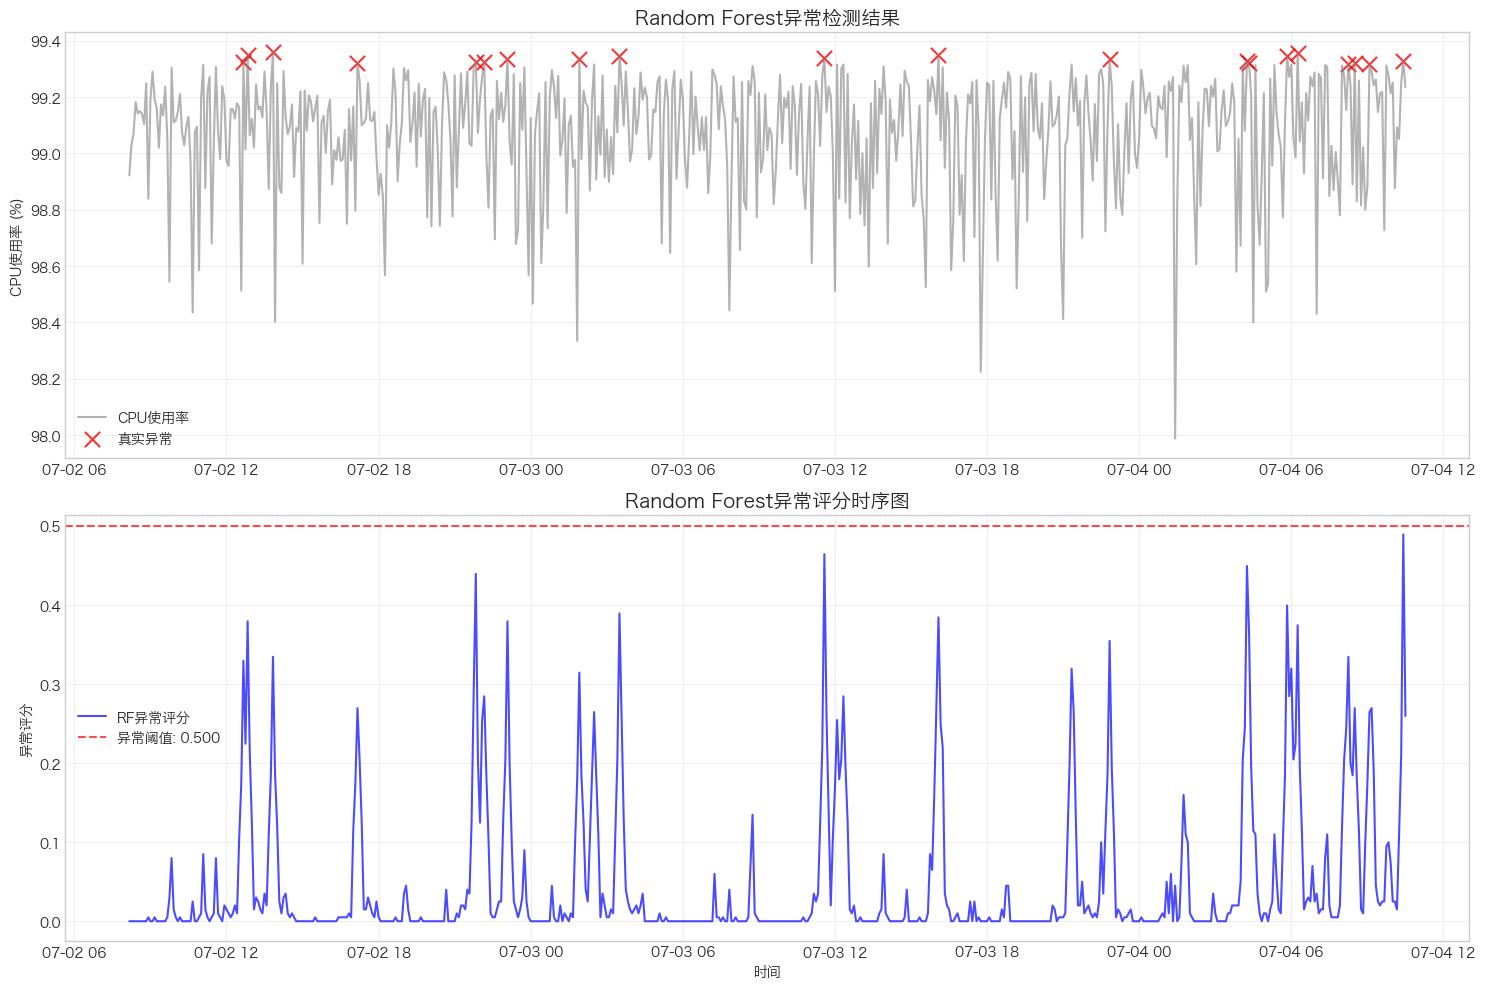

\n============================================================
📊 Random Forest异常检测摘要
总数据点: 605
真实异常: 20 (3.3%)
RF检测异常: 0 (0.0%)
\n⚡ RF检测优先级分布:
  P0:    0 点 (  0.0%)
  P1:    0 点 (  0.0%)
  P2:    0 点 (  0.0%)
  Normal:    0 点 (  0.0%)
\n📈 模型性能:
  精确率: 0.000
  召回率: 0.000
  F1分数: 0.000
\n🔍 Top 5 重要特征:
  Rolling Max 5: 0.152
  Relative Position: 0.103
  Rolling Max 3: 0.095
  Rolling Max 20: 0.085
  Rolling Mean 3: 0.081
\n🎉 Random Forest异常检测可视化完成！
📊 图表说明:
   上图: Random Forest异常检测结果 - 显示真实异常vs检测异常(按优先级分色)
   下图: 异常评分时序图 - Random Forest输出的置信度分数
\n✅ Random Forest异常检测评分器 - 完整分析完成！


In [156]:
# ============ 检测结果可视化 ============

def plot_random_forest_results(anomaly_report, figsize=(15, 10)):
    """绘制Random Forest异常检测结果（参考三维评分体系的简洁风格）"""
    print("🎨 生成Random Forest检测结果可视化...")
    
    # 确保中文字体设置
    plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Hiragino Sans GB', 'STHeiti', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # 时间轴处理
    if 'timestamp' in anomaly_report.columns:
        time_axis = anomaly_report['timestamp']
        xlabel = '时间'
    else:
        time_axis = range(len(anomaly_report))
        xlabel = '时间点'
    
    # 绘制原始数据和异常点
    ax1.plot(time_axis, anomaly_report['cpu_usage'], 
            label='CPU使用率', color='grey', alpha=0.6)
    
    # 绘制真实异常点
    true_anomalies = (anomaly_report['ground_truth'] == 1).fillna(False)
    if true_anomalies.any():
        ax1.scatter(time_axis[true_anomalies], anomaly_report[true_anomalies]['cpu_usage'], 
                   color='red', marker='x', s=120, label='真实异常', alpha=0.8)
    
    # 绘制不同优先级的Random Forest检测异常
    priority_colors = {'P0': 'darkred', 'P1': 'orange', 'P2': 'gold', 'Normal': 'lightgray'}
    priority_markers = {'P0': '*', 'P1': 'o', 'P2': 's', 'Normal': '.'}
    priority_sizes = {'P0': 200, 'P1': 120, 'P2': 80, 'Normal': 20}
    
    rf_anomalies = anomaly_report['is_rf_anomaly'].fillna(False)
    if rf_anomalies.any():
        rf_detected = anomaly_report[rf_anomalies]
        for priority in ['P0', 'P1', 'P2']:
            priority_mask = rf_detected['rf_priority'] == priority
            if priority_mask.any():
                priority_data = rf_detected[priority_mask]
                ax1.scatter(priority_data['timestamp'] if 'timestamp' in priority_data.columns else priority_data.index,
                           priority_data['cpu_usage'],
                           color=priority_colors[priority],
                           marker=priority_markers[priority],
                           s=priority_sizes[priority],
                           label=f'RF检测-{priority}',
                           alpha=0.8)
    
    ax1.set_title('Random Forest异常检测结果', fontsize=14, fontweight='bold')
    ax1.set_ylabel('CPU使用率 (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 绘制异常评分时序图
    ax2.plot(time_axis, anomaly_report['rf_anomaly_score'], 
            label='RF异常评分', color='blue', alpha=0.7)
    
    # 添加阈值线
    threshold = anomaly_classifier.thresholds['anomaly']
    ax2.axhline(y=threshold, color='red', linestyle='--', alpha=0.7,
               label=f'异常阈值: {threshold:.3f}')
    
    ax2.set_title('Random Forest异常评分时序图', fontsize=14, fontweight='bold')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('异常评分')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_detection_summary(anomaly_report, analysis_results):
    """打印检测结果摘要统计"""
    print("📊 Random Forest异常检测摘要")
    print("="*60)
    
    total_points = len(anomaly_report)
    rf_anomalies = anomaly_report['is_rf_anomaly'].fillna(False).sum()
    true_anomalies = (anomaly_report['ground_truth'] == 1).sum()
    
    print(f"总数据点: {total_points}")
    print(f"真实异常: {true_anomalies} ({true_anomalies/total_points*100:.1f}%)")
    print(f"RF检测异常: {rf_anomalies} ({rf_anomalies/total_points*100:.1f}%)")
    
    # 优先级分布
    print(f"\\n⚡ RF检测优先级分布:")
    priority_counts = anomaly_report['rf_priority'].value_counts()
    for priority in ['P0', 'P1', 'P2', 'Normal']:
        count = priority_counts.get(priority, 0)
        percentage = (count / total_points) * 100
        print(f"  {priority}: {count:4d} 点 ({percentage:5.1f}%)")
    
    # 性能指标
    print(f"\\n📈 模型性能:")
    cm = analysis_results['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"  精确率: {precision:.3f}")
    print(f"  召回率: {recall:.3f}")
    print(f"  F1分数: {f1:.3f}")
    
    # 特征重要性Top5
    print(f"\\n🔍 Top 5 重要特征:")
    top_features = analysis_results['feature_importance'].head(5)
    for _, row in top_features.iterrows():
        feature_name = row['feature'].replace('_', ' ').title()
        print(f"  {feature_name}: {row['importance']:.3f}")

# 生成简洁的可视化结果
print("🚀 开始生成Random Forest检测结果可视化...")
print("="*60)

# 简洁的主要检测结果图表
main_viz = plot_random_forest_results(anomaly_report, figsize=(15, 10))

print("\\n" + "="*60)

# 打印检测摘要
print_detection_summary(anomaly_report, analysis_results)

print("\\n🎉 Random Forest异常检测可视化完成！")
print("="*60)
print("📊 图表说明:")
print("   上图: Random Forest异常检测结果 - 显示真实异常vs检测异常(按优先级分色)")
print("   下图: 异常评分时序图 - Random Forest输出的置信度分数")
print("\\n✅ Random Forest异常检测评分器 - 完整分析完成！")